In [1]:
import torch
import torch.utils.data as tud
import argparse
import utils.chem as uc
import utils.scaffold as usc
import models.model as mm
import models.actions as ma
import models.dataset as mda
from rdkit import Chem
from rdkit.Chem import QED
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from join import fast_join
from tqdm import tqdm, trange
import csv
import json
import random
random.seed(42)

In [9]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [10]:
from chemprop.train.predict import predict
from chemprop.data import MoleculeDataLoader, get_data_from_smiles
from chemprop.utils import load_checkpoint, load_scalers
from chemprop.data import StandardScaler
from typing import Tuple
from Drug_Generation import prop_predict

def load_scalers(path: str) -> Tuple[StandardScaler, StandardScaler]:
    """
    Loads the scalers a model was trained with.

    :param path: Path where model checkpoint is saved.
    :return: A tuple with the data :class:`~chemprop.data.scaler.StandardScaler`
             and features :class:`~chemprop.data.scaler.StandardScaler`.
    """
    state = torch.load(path, map_location=lambda storage, loc: storage)

    scaler = StandardScaler(state['data_scaler']['means'],
                            state['data_scaler']['stds']) if state['data_scaler'] is not None else None
    features_scaler = StandardScaler(state['features_scaler']['means'],
                                     state['features_scaler']['stds'],
                                     replace_nan_token=0) if state['features_scaler'] is not None else None

    return scaler, features_scaler

def prop_model_load(chem_checkpoint):
    chem_model = load_checkpoint(chem_checkpoint)
    scaler, features_scaler = load_scalers(chem_checkpoint)
    #scaler = load_scalers(chem_checkpoint)
    return chem_model, scaler
def prop_model_load(chem_checkpoint):
    chem_model = load_checkpoint(chem_checkpoint)
    scaler, features_scaler = load_scalers(chem_checkpoint)
    return chem_model, scaler

In [11]:
class Reinforcement(object):
    def __init__(self, generator, perdictor, get_reward):

        super(Reinforcement, self).__init__()
        self.generator = generator
        self.predictor = predictor
        self.get_reward = get_reward

    def policy_gradient(self, data, n_batch=10, gamma=0.97, grad_clipping=None, **kwargs):

        rl_loss = 0
        self.generator.optimizer.zero_grad()
        total_reward = 0

        for _ in range(n_batch):
            rewards = []
            while rewards == []:
                try:
                    trajectory, scaffold, decoration = self.generator.evaluate(next(data))
                    rewards = self.get_reward(trajectory, self.predictor)
                except:

                    rewards=[]

            discounted_rewards = rewards
            total_reward += np.sum(rewards)
            scaffold_decoration_smi_list = list(map(list, zip(scaffold, decoration)))
            rl_loss, idx = self.generator.compute_loss(scaffold_decoration_smi_list, discounted_rewards, gamma)
            n_batch += (idx-1)

        rl_loss = rl_loss / n_batch
        total_reward = total_reward / n_batch
        self.generator.model.set_mode("train")
        rl_loss.backward()
    
#         if grad_clipping is not None:
#                 torch.nn.utils.clip_grad_norm_(self.generator.parameters(), 
#                                                grad_clipping)

        self.generator.optimizer.step()
        
        return total_reward, rl_loss.item()
        

In [12]:
class Generator(object):
    def __init__(self, params):
#         self.model = mm.DecoratorModel.load_from_file(params.input_model_path, mode="eval")
        self.model = mm.DecoratorModel.load_from_file("./jak2_decorator/models/model.trained.50")
        self.optimizer = torch.optim.Adam(self.model.network.parameters(), lr=1E-4)
        self.sample_model_action = ma.SampleModel(self.model, batch_size=16)
        self.nll_loss = torch.nn.NLLLoss()

        
    def evaluate(self, input_smiles):
        #self.model.set_mode("eval")
        samples_df = fast_join([input_smiles], self.sample_model_action) #must remove 'Failed'
        trajectory = samples_df["smiles"]
        scaffold = samples_df["clean_scaffold"]
        decoration= samples_df["decoration_smi"]
        return list(trajectory), list(scaffold), list(decoration)
    
    
    def parameters(self):
        return self.model.get_params()
    
    def compute_loss(self, scaffold_decoration_smi_list, discounted_rewards, gamma):
        #output = []
        dataloader = self.initialize_dataloader(scaffold_decoration_smi_list)
        seq_lengths = torch.ones(1)
        nlls = torch.zeros(1).cuda()
        idx=0
        for s,d in dataloader:
            discounted_reward = discounted_rewards[idx]
#             scaffold_seqs, scaffold_seq_lengths = s
#             decoration_seqs, decoration_seq_lengths = d
#             global probs
#             probs = torch.zeros(scaffold_seqs.size(1), len(self.model.vocabulary)[0])
            

            encoder_padded_seqs, hidden_states = generator.model.network.forward_encoder(*s)
            encoder_padded_seqs = encoder_padded_seqs.unsqueeze(dim=0)

            (hs_h, hs_c) = hidden_states
            hs_h = hs_h.unsqueeze(dim=1)
            hs_c = hs_c.unsqueeze(dim=1)

            for i in range(d[1].item()-1): #decoration_seq_lengths
                logits, _, attention_weights = generator.model.network.forward_decoder(
                        d[0][:,i].unsqueeze(dim=0), seq_lengths, encoder_padded_seqs, (hs_h, hs_c))               
                #logits.softmax(dim=2).squeeze() # decoration seq x vocab
                nlls += self.nll_loss(logits.log_softmax(dim=2).reshape((1,-1)), d[0][:,i+1])*discounted_reward
                discounted_reward = discounted_reward * gamma            
            idx+=1

        return nlls, idx

                    
    def initialize_dataloader(self, training_set):
        dataset = mda.DecoratorDataset(training_set, vocabulary=self.model.vocabulary)
        #print(len(dataset))
        return tud.DataLoader(dataset, batch_size=1, shuffle=False,
                              collate_fn=mda.DecoratorDataset.collate_fn, drop_last=False)

In [14]:
class CustomPredictor(object):
    def __init__(self, negative_sign = True, 
            model_dir='/home/sumin/Retro/reinvent-scaffold-decorator/Drug_Generation/model/model.pt',
            multi_objective=None):
        self.model_dir = model_dir
        self.chem_model, self.scaler = prop_model_load(self.model_dir)
        self.negative_sign = negative_sign
        self.multi_objective = multi_objective #float
        self.processed_smiles, self.invalid_smiles = [], []


    def check_smiles(self, input_smiles):
        processed_smiles = []
        invalid_smiles = []
        for sm in input_smiles:
            try:
                mol = Chem.MolFromSmiles(sm, sanitize=True)
                #qed = QED.qed(mol)
                processed_smiles.append(sm)
            except:
                invalid_smiles.append(sm)
                continue
        return processed_smiles, invalid_smiles

    def predict(self, objects=None, **kwargs):
        self.processed_smiles, self.invalid_smiles = self.check_smiles(objects)
        #pdb.set_trace()
        prediction = np.array(prop_predict.get_result(self.processed_smiles, self.chem_model, self.scaler))
        if self.negative_sign:
            prediction = prediction * (-1)
#         if self.multi_objective:
#             mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in self.processed_smiles]
#             contraint_score = np.array([QED.qed(mol) for mol in mols])
# #            print("QED: ", contraint_score)
# #            print("BA: ", prediction)
#             multi_objective_score = contraint_score * self.multi_objective + prediction * (1 - self.multi_objective)
# #            print("mult_score: ", prediction)
#             return self.processed_smiles, prediction, multi_objective_score, self.invalid_smiles
        return self.processed_smiles, prediction, self.invalid_smiles

In [15]:
def plot_hist(prediction, n_to_generate, label="ba"):
    print("Mean value of predictions:", prediction.mean())
    ax = sns.kdeplot(prediction, shade=True)
    ax.set(xlabel=f'Predicted {label}', 
           title=f'Distribution of predicted {label} for generated molecules')
    plt.show()
import pdb
def estimate_and_update(generator, predictor, gen_data, n_to_generate, **kwargs):
    generated = []
    buffer = []
    
    with tqdm(total=n_to_generate) as pbar:
        while True:
            pbar.set_description("Generating molecules...")
            try:
                trajectory = generator.evaluate(next(gen_data))[0][0]
                #pdb.set_trace()
                mol = Chem.MolFromSmiles(trajectory, sanitize=False)
                smiles = Chem.MolToSmiles(mol)
                qed = QED.qed(mol)
                generated.append(smiles)
                pbar.update(1)
            except:
                continue
            if len(list(np.unique(generated))[1:]) == n_to_generate:
                break

    unique_smiles = list(np.unique(generated))[1:]
#     if predictor.multi_objective:
#         smiles, prediction, multi_objective_score, nan_smiles = predictor.predict(unique_smiles, get_features=get_fp)
#         plot_hist(multi_objective_score, n_to_generate, label="multi_objective_score")
#         plot_hist(prediction, n_to_generate)
#         return smiles, prediction, multi_objective_score
#     else :
#         smiles, prediction, nan_smiles = predictor.predict(unique_smiles, get_features=get_fp)  
#     plot_hist(prediction, n_to_generate)
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles)
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction

In [16]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

def get_reward_max(smiles, predictor, invalid_reward=0.0, get_features=None):
    if predictor.multi_objective:
        mol, original_prop, prop, nan_smiles = predictor.predict(smiles, get_features=get_features)
    else:
        mol, prop, nan_smiles = predictor.predict(smiles, get_features=get_features)
    if (len(nan_smiles) == 1):
        return invalid_reward
    return np.exp(prop/3)

def parse_args():
    parser = argparse.ArgumentParser(
                description="Train model with RL.")
    parser.add_argument("--input-model-path", "-i", help="Input model file", type=str, default ="jak2_decorator/models/model.trained.50" )
    parser.add_argument("--output-model-prefix-path", "-o",
                            help="Prefix to the output model (may have the epoch appended).", type=str, default ="jak2_decorator/rl_models/model.trained.50")
#     parser.add_argument("--training-set-path", "-s", help="Path to a file with (scaffold, decoration) tuples \
#             or a directory with many of these files to be used as training set.", type=str, required=True)
        # parser.add_argument("--batch_size")

    return parser.parse_args(args=[])

def getData(file_path):
    with open(file_path, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            try:
                yield choose_scaffold(row)
            except:
                continue



with open("conditions.json.example", "r") as json_file:
    data = json.load(json_file)
    if "scaffold" in data:
        scaffold_conditions = data["scaffold"]
    if "decoration" in data:
        decoration_conditions = data["decoration"]
enumerator = usc.SliceEnumerator(usc.SLICE_SMARTS["recap"],scaffold_conditions, decoration_conditions)

def choose_scaffold(row, max_cuts=4, enumerator=enumerator):
            smiles = row[0]
            mol = uc.to_mol(smiles)
            out_rows = []
            if mol:
                for cuts in range(1, max_cuts + 1):
                    for sliced_mol in enumerator.enumerate(mol, cuts=cuts):
                        scaff_smi, dec_smis = sliced_mol.to_smiles()
                        out_rows.append(scaff_smi)
            scaff = random.choice(out_rows)
            return scaff


In [10]:
#get_reward_max('CCC1(n2cc(C(N)=O)c(Nc3ccccc3)n2)CCN(C(=O)C=Cc2cc(Cl)cc(CN3CCN(C)CC3)c2)CC1', predictor)

In [ ]:
PREDICTOR_MODEL_PATH = './Drug_Generation/model/model.pt'

### main() starts here

In [18]:
params = parse_args()
generator = Generator(params)
predictor = CustomPredictor(negative_sign=True, model_dir=PREDICTOR_MODEL_PATH)
get_reward = get_reward_max
RL_max = Reinforcement(generator, predictor, get_reward)
gen_data = getData("./training_sets/jak2_smiles.csv")

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Moving model to cuda


Generating molecules...: : 1015it [01:59,  8.52it/s]                        


Mean value of predictions: 7.824454503041676


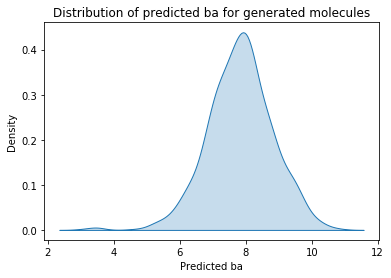

['C1=CCOCc2cc(ccc2OCCN2CCCC2)Nc2nccc(n2)-c2cccc(c2)COC1', 'C=C(C(=O)Nc1ccc(C)cc1C)C(=O)Nc1ccc(C)cc1C', 'C=C(C)C(=O)Nc1cc(-c2ncnc3[nH]cc(C(=O)OCC)c23)cc(OC)n1', 'C=C(C)C(=O)Nc1cc(-c2ncnc3[nH]cc(C(=O)OCC)c23)ccn1', 'C=C(C)C(=O)Nc1cccc(-c2cn[nH]c2)c1', 'C=C(C)C(=O)Nc1cccc(-c2ncnc3[nH]cc(C(=O)OCC(C)O)c23)c1', 'C=C(C)C(=O)Nc1cccc(CNc2cc(Nc3cnn(C)c3)ncn2)c1', 'C=C(C)C(C)NC(=O)c1c[nH]c2ncc(C3CC3)nc12', 'C=C(C)Nc1ccc(-c2ccnc(Nc3ccc(CN4CCS(=O)(=O)CC4)cc3)n2)cc1', 'C=C(CC#N)N1CCC(C)C12CCN(c1ncnc3[nH]ccc13)C2'] [5.23622894 4.64453102 6.28220397 5.81524863 5.85532914 5.82980796
 6.04054325 7.09819582 8.83365348 7.79891589]


In [19]:
generated_smiles, generated_scores = estimate_and_update(generator, predictor, gen_data, 1000)
print(generated_smiles[:10], generated_scores[:10])

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.51it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.67it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

0th cur_reward, cur_loss:  15.71381264927003 36.035667419433594



100%|██████████| 1/1 [00:00<00:00,  5.06it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.86it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

1th cur_reward, cur_loss:  13.603625101094298 67.1656723022461



100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.94it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.58it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

2th cur_reward, cur_loss:  13.596531919703548 250.7378387451172



100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.93it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

3th cur_reward, cur_loss:  11.135190031589227 174.8502197265625



100%|██████████| 1/1 [00:00<00:00,  4.79it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.91it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.90it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

4th cur_reward, cur_loss:  10.775525202680997 81.66584777832031



100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.89it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.20it/s]
                                             
Policy gradient...:  40%|████      | 6/15 [00:15<00:23,  2.60s/it]

5th cur_reward, cur_loss:  14.79570040443038 232.54037475585938



100%|██████████| 1/1 [00:00<00:00,  4.86it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.95it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

6th cur_reward, cur_loss:  10.098153435519828 56.08955383300781



100%|██████████| 1/1 [00:00<00:00,  4.84it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.98it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:21<00:18,  2.59s/it]

7th cur_reward, cur_loss:  15.047647428818482 255.21144104003906



100%|██████████| 1/1 [00:00<00:00,  3.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.90it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

8th cur_reward, cur_loss:  13.782402241710157 277.03936767578125



100%|██████████| 1/1 [00:00<00:00,  4.96it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.84it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  5.04it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

9th cur_reward, cur_loss:  14.866270755219736 108.75889587402344



100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.95it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [00:29<00:11,  2.75s/it]

10th cur_reward, cur_loss:  16.33844502369637 183.0010528564453



100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.55it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

11th cur_reward, cur_loss:  14.38143249861009 783.2191772460938



100%|██████████| 1/1 [00:00<00:00,  4.19it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.79it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.90it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.28it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

12th cur_reward, cur_loss:  12.348131154963571 89.47675323486328



100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.98it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.98it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.90it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

13th cur_reward, cur_loss:  12.901053739887454 229.5793914794922



100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.82it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [00:52<00:00,  3.48s/it]


14th cur_reward, cur_loss:  15.707798120795175 179.60714721679688


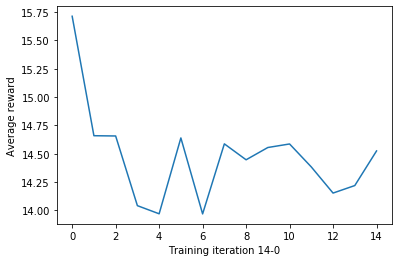

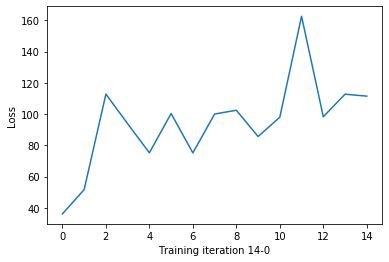

Generating molecules...: : 11it [00:08,  1.37it/s]                      


Mean value of predictions: 7.679184545078246


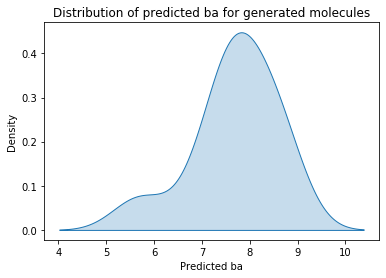

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

0th Sample trajectories:
CC1CC1CN1C(=O)CCN1C(=O)N(C1CC1)C1CC(C(=O)N2CCC(=O)N(C)C(N)C(C)C2)C(Cn2cc(C(N)=O)c(Nc3ccccc3)n2)C(N(C)c2nccc(F)c2NC2CC(=O)C(N(C)C)C2)C1
CC1N(c2ncnc3[nH]ccc23)CCC12CCCN2S(C)(=O)=O
CN(C)CCNC(=O)c1cc2c(NC3(C)CN(S(=O)(=O)C(C)(C)C)C3)nc(-n3cnc4ccncc43)nc2n1C
CN(C1CCCCC1)C1CCC1
CN(CC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1)C1CCC(C)(N)C1=O
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.90it/s]
                                             
Policy gradient...:   7%|▋         | 1/15 [00:07<01:40,  7.20s/it]

0th cur_reward, cur_loss:  11.330126813492342 48.135528564453125



100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.98it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.86it/s]
                                             
Policy gradient...:  13%|█▎        | 2/15 [00:20<02:20, 10.77s/it]

1th cur_reward, cur_loss:  15.4124014320588 143.14305114746094



100%|██████████| 1/1 [00:00<00:00,  4.99it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  5.00it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.90it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:28<01:53,  9.49s/it]

2th cur_reward, cur_loss:  12.748224117525119 95.32764434814453



100%|██████████| 1/1 [00:00<00:00,  4.93it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.96it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [00:43<02:08, 11.64s/it]

3th cur_reward, cur_loss:  13.313880656153618 114.86213684082031



100%|██████████| 1/1 [00:00<00:00,  4.88it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.86it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:58<02:10, 13.06s/it]

4th cur_reward, cur_loss:  10.75645933741308 122.3648452758789



100%|██████████| 1/1 [00:00<00:00,  4.93it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.93it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
                                             
Policy gradient...:  40%|████      | 6/15 [01:18<02:17, 15.32s/it]

5th cur_reward, cur_loss:  14.928204220708341 67.32523345947266



100%|██████████| 1/1 [00:00<00:00,  4.84it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.91it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.99it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  5.02it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [01:45<02:31, 18.97s/it]

6th cur_reward, cur_loss:  13.777936384250678 32.22602462768555



100%|██████████| 1/1 [00:00<00:00,  5.11it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  5.11it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  5.05it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [02:19<02:47, 23.90s/it]

7th cur_reward, cur_loss:  13.387598427103788 108.51531982421875



100%|██████████| 1/1 [00:00<00:00,  4.96it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.96it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  5.05it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  5.03it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [02:33<02:03, 20.64s/it]

8th cur_reward, cur_loss:  13.680605890640232 39.65437698364258



100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.96it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.90it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [02:57<01:49, 21.84s/it]

9th cur_reward, cur_loss:  12.539667261616128 59.41505813598633



100%|██████████| 1/1 [00:00<00:00,  4.75it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [03:51<02:06, 31.73s/it]

10th cur_reward, cur_loss:  12.147737427653919 48.41566848754883



100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.96it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [04:54<02:03, 41.21s/it]

11th cur_reward, cur_loss:  17.092702312830426 97.36675262451172



100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.84it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [05:49<01:30, 45.47s/it]

12th cur_reward, cur_loss:  10.491533966923704 67.71638488769531



100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.93it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.79it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [06:28<00:43, 43.48s/it]

13th cur_reward, cur_loss:  14.351989847755586 115.37471008300781



100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [07:15<00:00, 29.06s/it]

14th cur_reward, cur_loss:  12.528957468708915 117.67535400390625


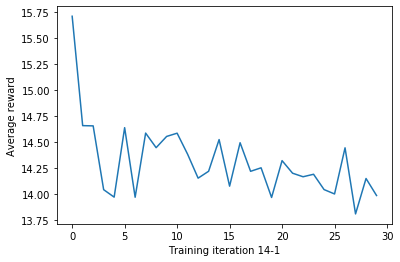

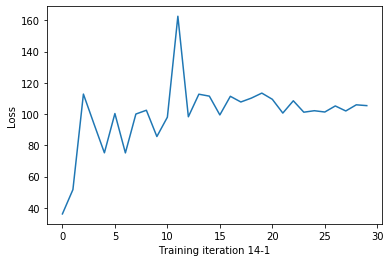

Generating molecules...: : 11it [00:40,  3.71s/it]                      


Mean value of predictions: 7.968717163370648


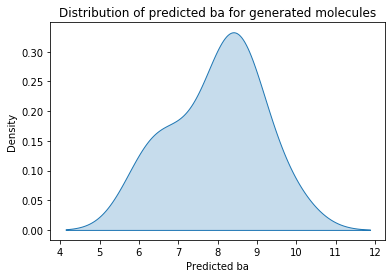

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

1th Sample trajectories:
CC(C)(C)N(NCC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1)C(C)(C)C
CC(C)(C)N1CC(CC#N)(n2cc(C(N)=O)c(Nc3ccc(S(C)(=O)=O)cc3)n2)C1
CC(C)(C)NN1CCC(c2ccc(Nc3ncc4ccc(-c5cccc(S(=O)(=O)NC(C)(C)C)c5)n4n3)cc2)CC1
CC1(C#N)CCCN2CC(Oc3ccc(Nc4nc(N)nc(CCl)n4)cc3)C21C
CC1(C)CN(C(C)(C#N)C(N)=O)CC1c1cc2c(NC34CC5CC(O)(CC(O)(C5)C3)C4)c(C(N)=O)cnn2c1
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.90it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.82it/s]
                                             
Policy gradient...:   7%|▋         | 1/15 [00:45<10:30, 45.05s/it]

0th cur_reward, cur_loss:  10.760881926949889 59.508026123046875



100%|██████████| 1/1 [00:00<00:00,  5.00it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.81it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  4.88it/s]
                                             
Policy gradient...:  13%|█▎        | 2/15 [01:36<10:30, 48.54s/it]

1th cur_reward, cur_loss:  12.727166971444058 54.853233337402344



100%|██████████| 1/1 [00:00<00:00,  4.81it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [01:46<06:11, 30.94s/it]

2th cur_reward, cur_loss:  12.040671120485163 81.92427062988281



100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.96it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [02:43<07:36, 41.47s/it]

3th cur_reward, cur_loss:  15.636955440910711 103.23844146728516



100%|██████████| 1/1 [00:00<00:00,  4.91it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.81it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [03:31<07:19, 43.92s/it]

4th cur_reward, cur_loss:  12.245511014761782 78.52791595458984



100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.88it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.84it/s]
                                             
Policy gradient...:  40%|████      | 6/15 [04:09<06:15, 41.70s/it]

5th cur_reward, cur_loss:  17.344182828762413 133.7666778564453



100%|██████████| 1/1 [00:00<00:00,  4.84it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.86it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.96it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [04:32<04:45, 35.67s/it]

6th cur_reward, cur_loss:  11.861321743462401 61.584877014160156



100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.22it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.75it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [04:46<03:21, 28.76s/it]

7th cur_reward, cur_loss:  13.819948160044504 81.37904357910156



100%|██████████| 1/1 [00:00<00:00,  4.91it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [05:08<02:39, 26.64s/it]

8th cur_reward, cur_loss:  13.146869434676399 117.63560485839844



100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.95it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.84it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [05:21<01:52, 22.59s/it]

9th cur_reward, cur_loss:  12.466506023441704 11.955122947692871



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.86it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.88it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

10th cur_reward, cur_loss:  12.461407954096183 63.30772399902344



100%|██████████| 1/1 [00:00<00:00,  4.67it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [05:38<00:45, 15.24s/it]

11th cur_reward, cur_loss:  14.970861036502631 47.33268737792969



100%|██████████| 1/1 [00:00<00:00,  4.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.91it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [05:42<00:23, 11.95s/it]

12th cur_reward, cur_loss:  15.440286768353383 156.0294952392578



100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.86it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

13th cur_reward, cur_loss:  11.848765411504962 44.03632736206055



100%|██████████| 1/1 [00:00<00:00,  4.50it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.18it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [05:57<00:00, 23.86s/it]


14th cur_reward, cur_loss:  15.243177398820018 34.31503677368164


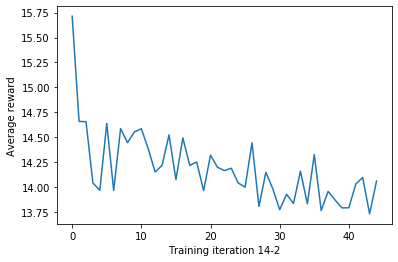

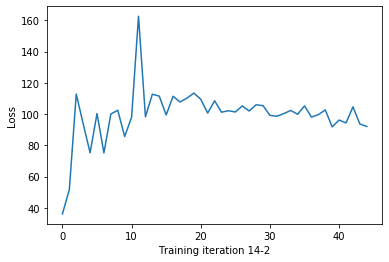

Generating molecules...: : 11it [00:04,  2.42it/s]                      


Mean value of predictions: 7.815964975849637


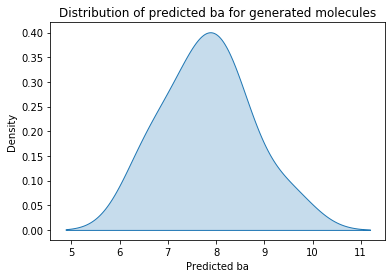

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

2th Sample trajectories:
CC(C)(C)C(=O)c1cn(C2(CC#N)CCC(Nc3ccc(Cl)cc3)CC2)nc1Nc1ccnc(F)c1
CC(C)(N)CC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1
CC(C)[N+](C)([O-])N1CCC(c2nnn3cnc4[nH]ccc4c23)CC1
CC(c1ccccc1)N(C)c1ccnc(-n2cnc3ccncc32)n1
CCN(CCC(=O)Nc1cc2cc(c1)Nc1nccc(n1)-c1cccc(c1)COCC=CCOC2)N(C)C
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.86it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.17it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

0th cur_reward, cur_loss:  15.980050498531371 63.108787536621094



100%|██████████| 1/1 [00:00<00:00,  4.17it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.19it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.88it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.90it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

1th cur_reward, cur_loss:  13.773459681403466 30.008344650268555



100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.84it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:13<00:55,  4.61s/it]

2th cur_reward, cur_loss:  15.590572012099598 79.6933822631836



100%|██████████| 1/1 [00:00<00:00,  4.93it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.98it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

3th cur_reward, cur_loss:  11.800567720434524 57.06382369995117



100%|██████████| 1/1 [00:00<00:00,  4.94it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.82it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:26<00:59,  5.96s/it]

4th cur_reward, cur_loss:  16.33735026688236 24.444974899291992



100%|██████████| 1/1 [00:00<00:00,  4.93it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.81it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.82it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                                             
Policy gradient...:  40%|████      | 6/15 [00:31<00:50,  5.60s/it]

5th cur_reward, cur_loss:  12.092071124822022 38.7618408203125



100%|██████████| 1/1 [00:00<00:00,  4.79it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.93it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.84it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

6th cur_reward, cur_loss:  12.715837899464802 35.85337448120117



100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.90it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.91it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:46<00:47,  6.75s/it]

7th cur_reward, cur_loss:  10.977209933729318 75.46414947509766



100%|██████████| 1/1 [00:00<00:00,  3.74it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.17it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.18it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [00:50<00:34,  5.83s/it]

8th cur_reward, cur_loss:  12.889240327489592 34.47536087036133



100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.75it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [00:54<00:26,  5.37s/it]

9th cur_reward, cur_loss:  14.129734120975952 46.70498275756836



100%|██████████| 1/1 [00:00<00:00,  4.97it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  5.00it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.81it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

10th cur_reward, cur_loss:  11.594186238654256 35.38483428955078



100%|██████████| 1/1 [00:00<00:00,  4.86it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.91it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [01:05<00:16,  5.46s/it]

11th cur_reward, cur_loss:  9.503479190623578 50.06020736694336



100%|██████████| 1/1 [00:00<00:00,  4.86it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.90it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.88it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [01:14<00:13,  6.57s/it]

12th cur_reward, cur_loss:  10.48662744338606 15.361108779907227



100%|██████████| 1/1 [00:00<00:00,  4.93it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.79it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.93it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:19<00:05,  5.91s/it]

13th cur_reward, cur_loss:  11.603737440569834 46.13829040527344



100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:32<00:00,  6.14s/it]

14th cur_reward, cur_loss:  14.870121461562155 77.40686798095703


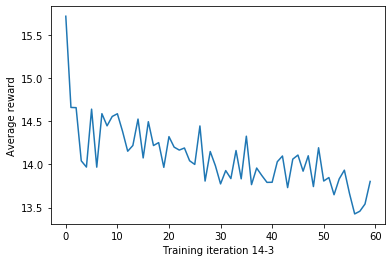

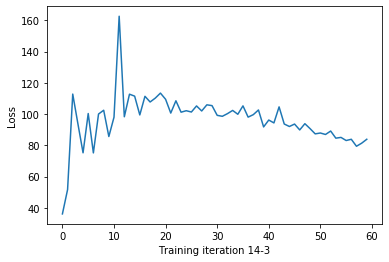

Generating molecules...: : 11it [00:08,  1.22it/s]                      


Mean value of predictions: 7.026208414336573


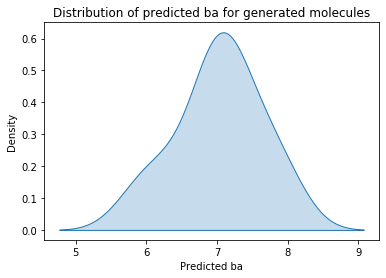

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

3th Sample trajectories:
CC(C(=O)N(C)C)C1CCN(S(=O)(=O)CC2CCC(N(C)c3ncnc4[nH]ccc34)CC2)C1
CCC1CN(C(=O)C2(C#N)CC2)CC1Nc1c(C(N)=O)cnn2cc(C(=O)N(C)C)nc12
CN(C)C(=O)N1CCC(C)(C(F)(F)F)C(=O)N(C)C1c1cccc(-n2c(=O)[nH]c3c(F)cccc3c2=O)c1Cl
CN(C)C(=O)c1cnc(Nc2ccccc2)cc1NCc1ccccc1
CN(C)C(=O)n1cc(C(N)=O)c(Nc2ccccc2)n1
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.82it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.86it/s]
                                             
Policy gradient...:   7%|▋         | 1/15 [00:07<01:44,  7.45s/it]

0th cur_reward, cur_loss:  12.853359378408948 102.0650405883789



100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
Policy gradient...:  13%|█▎        | 2/15 [00:16<01:49,  8.42s/it]

1th cur_reward, cur_loss:  13.720788049458685 22.629573822021484



100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.82it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:19<01:13,  6.12s/it]

2th cur_reward, cur_loss:  13.903836852289176 19.125015258789062



100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.94it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [00:32<01:35,  8.64s/it]

3th cur_reward, cur_loss:  11.912794083307721 66.20568084716797



100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.84it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  2.76it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:38<01:18,  7.89s/it]

4th cur_reward, cur_loss:  11.875749726711774 41.25490951538086



100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.28it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.81it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                                             
Policy gradient...:  40%|████      | 6/15 [00:48<01:17,  8.56s/it]

5th cur_reward, cur_loss:  11.63108882624302 54.23038101196289



100%|██████████| 1/1 [00:00<00:00,  4.82it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.84it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:56<01:06,  8.28s/it]

6th cur_reward, cur_loss:  14.269010759215938 85.45108032226562



100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.81it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.82it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [01:05<01:00,  8.59s/it]

7th cur_reward, cur_loss:  11.878215556844678 82.6917724609375



100%|██████████| 1/1 [00:00<00:00,  4.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.84it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

8th cur_reward, cur_loss:  14.281176385937268 41.22159194946289



100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.86it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

9th cur_reward, cur_loss:  11.184360595646712 48.520320892333984



100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [01:21<00:24,  6.23s/it]

10th cur_reward, cur_loss:  14.957831252300508 34.72186279296875



100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.81it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [01:28<00:19,  6.34s/it]

11th cur_reward, cur_loss:  13.3040108956089 28.927936553955078



100%|██████████| 1/1 [00:00<00:00,  4.88it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.79it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [01:41<00:17,  8.62s/it]

12th cur_reward, cur_loss:  11.725171406911604 46.74344253540039



100%|██████████| 1/1 [00:00<00:00,  4.94it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.86it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.95it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:52<00:09,  9.30s/it]

13th cur_reward, cur_loss:  13.313790132623605 27.411710739135742



100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.82it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.91it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:56<00:00,  7.79s/it]


14th cur_reward, cur_loss:  10.595562570541743 19.692737579345703


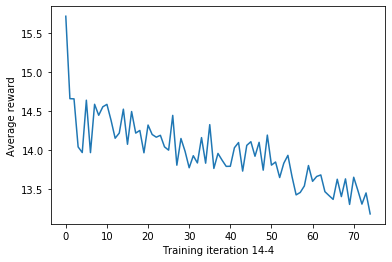

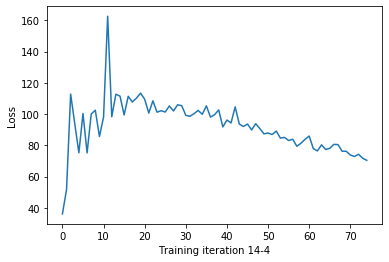

Generating molecules...: : 11it [00:09,  1.10it/s]                      


Mean value of predictions: 7.635593080661499


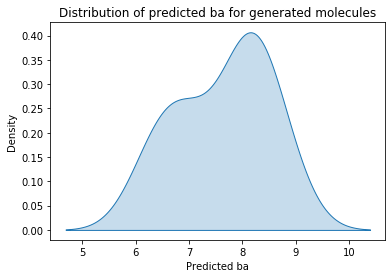

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

4th Sample trajectories:
CC(C)(C)C(=O)c1cn(C2(CC#N)CCN(Cc3ccccc3C#N)CC2)nc1Nc1ccnc(F)c1
CCC(C(=O)C1CCN(c2ccc(Nc3nccc(-c4ccc(C(=O)NCC#N)cc4)n3)cc2)CC1)N(C)C
CCC1CN(C(=O)C2(C#N)CC2)CC1Nc1c(C(=O)C(C)(C)N(C)C)cnn2cc(-c3cnn(C(F)F)c3)nc12
CN(C(=O)C(C)(C)N(C)C)C(C(=O)c1cn(C2CCCCC2C#N)nc1Nc1ccc(Cl)c(Cl)c1)C(C)(C)C
CN(C)C(=O)C(=O)c1cnn2cccc2c1NC1CCCC1(C)C
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                                             
Policy gradient...:   7%|▋         | 1/15 [00:12<02:59, 12.81s/it]

0th cur_reward, cur_loss:  12.296508548326386 21.85801124572754



100%|██████████| 1/1 [00:00<00:00,  4.22it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.50it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                                             
Policy gradient...:  13%|█▎        | 2/15 [00:20<02:07,  9.79s/it]

1th cur_reward, cur_loss:  13.658982145572299 45.630428314208984



100%|██████████| 1/1 [00:00<00:00,  4.75it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:26<01:37,  8.14s/it]

2th cur_reward, cur_loss:  14.272054047881872 37.26118469238281



100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [00:33<01:24,  7.65s/it]

3th cur_reward, cur_loss:  13.322595470165556 23.14435386657715



100%|██████████| 1/1 [00:00<00:00,  3.65it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

4th cur_reward, cur_loss:  12.674780437905435 33.168701171875



100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

5th cur_reward, cur_loss:  13.165893523039625 16.424758911132812



100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:46<00:42,  5.31s/it]

6th cur_reward, cur_loss:  13.240672088148155 5.3976359367370605



100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

7th cur_reward, cur_loss:  15.782760630624583 24.804372787475586



100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.12it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [00:58<00:32,  5.48s/it]

8th cur_reward, cur_loss:  14.27168331169553 31.657926559448242



100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.19it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [01:06<00:31,  6.27s/it]

9th cur_reward, cur_loss:  11.397601361551304 56.46394348144531



100%|██████████| 1/1 [00:00<00:00,  4.19it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.67it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [01:11<00:23,  5.89s/it]

10th cur_reward, cur_loss:  14.89065264749363 21.9766902923584



100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

11th cur_reward, cur_loss:  12.837975835944798 39.96998977661133



100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.86it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.67it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [01:21<00:10,  5.39s/it]

12th cur_reward, cur_loss:  19.070380021099407 103.33794403076172



100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.57it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:30<00:06,  6.37s/it]

13th cur_reward, cur_loss:  12.25797580969042 21.52846908569336



100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:42<00:00,  6.83s/it]

14th cur_reward, cur_loss:  13.560527583918477 69.25788879394531


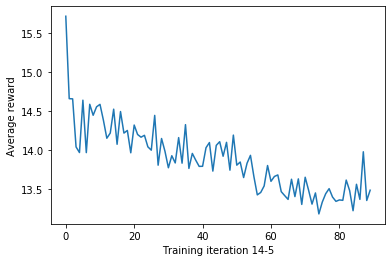

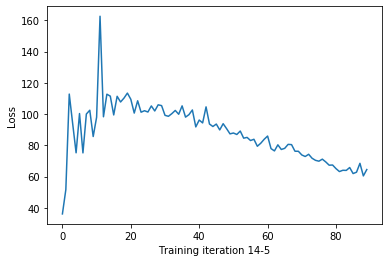

Generating molecules...: : 11it [00:09,  1.20it/s]                      


Mean value of predictions: 7.501149805773602


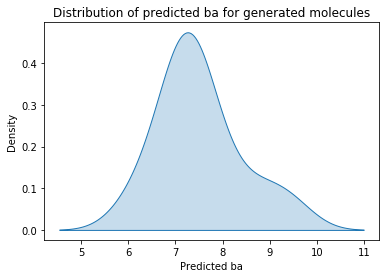

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

5th Sample trajectories:
CC(C)(C)C(=O)CCCCCCC(=O)Nc1ccc(-c2ccnc(Nc3cccc(N4CCCCC4)c3)n2)cc1
CC(C)(C)N1CC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2)C1
CC(Oc1cc(C(=O)C2CCC2N2CC2)cnc1N)C1CCCCC1
CC1(C)CN(C(N)=O)CC(=O)C1n1cc(C(N)=O)c(Nc2ccnc(F)c2)n1
CC1(C)CN(N(c2ncnc3[nH]ccc23)C2CC(CS(=O)(=O)NCC3CC3)C2)C1
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                                             
Policy gradient...:   7%|▋         | 1/15 [00:03<00:55,  3.99s/it]

0th cur_reward, cur_loss:  17.56018633598077 81.95849609375



100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

1th cur_reward, cur_loss:  14.578430033790736 123.31025695800781



100%|██████████| 1/1 [00:00<00:00,  3.54it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.57it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

2th cur_reward, cur_loss:  11.46415347156081 13.90373420715332



100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.50it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [00:25<01:10,  6.39s/it]

3th cur_reward, cur_loss:  16.026560811287606 74.48092651367188



100%|██████████| 1/1 [00:00<00:00,  3.72it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.65it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:29<00:57,  5.72s/it]

4th cur_reward, cur_loss:  11.666296729980344 63.19444274902344



100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.58it/s]
                                             
Policy gradient...:  40%|████      | 6/15 [00:42<01:11,  7.99s/it]

5th cur_reward, cur_loss:  13.089666814567506 36.966552734375



100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:46<00:53,  6.69s/it]

6th cur_reward, cur_loss:  12.525551407253213 26.447406768798828



100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:50<00:42,  6.05s/it]

7th cur_reward, cur_loss:  12.285807259211813 49.90717315673828



100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.22it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

8th cur_reward, cur_loss:  14.647216183778255 72.69568634033203



100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

9th cur_reward, cur_loss:  12.454539227533624 124.4775161743164



100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [01:09<00:25,  6.28s/it]

10th cur_reward, cur_loss:  11.957215264908182 22.059185028076172



100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [01:18<00:21,  7.27s/it]

11th cur_reward, cur_loss:  10.376231551304604 43.08528137207031



100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.51it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.58it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [01:22<00:12,  6.21s/it]

12th cur_reward, cur_loss:  11.816765016253465 41.46501159667969



100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.20it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

13th cur_reward, cur_loss:  11.435604708919083 34.41417694091797



100%|██████████| 1/1 [00:00<00:00,  3.96it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.67it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:32<00:00,  6.19s/it]

14th cur_reward, cur_loss:  10.358906919241745 56.356964111328125


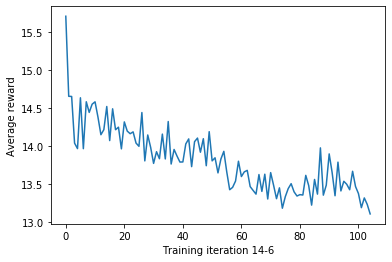

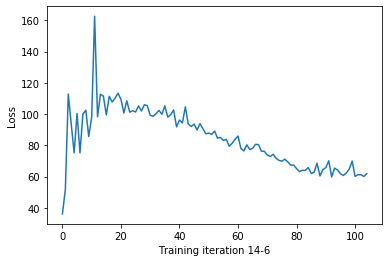

Generating molecules...: : 11it [00:20,  1.86s/it]                      


Mean value of predictions: 6.654674505144067


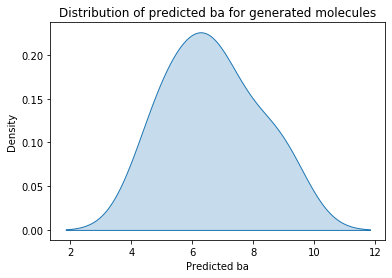

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

6th Sample trajectories:
CC(C)(C)C(=O)Nc1nc(N2CC(C#N)C2)ncc1-c1cnc2[nH]ccc2n1
CC1CCN(S(C)(=O)=O)CC1Nc1ncccc1-c1cnc2[nH]ccc2n1
CC1CN(C(=O)C2(C#N)CCC(C3CCC3)C2)CC12CC2
CCN(C(=O)C(C)(C)C)N(c1ccc2[nH]c(=O)[nH]c2n1)C1CCN(c2ncnc3[nH]ccc23)C1
CCN(CC)C(=O)COCC(C)C1CCC(C)C(C2CCC([N+](C)([O-])C3CC(C)(C)C3)CC2)C1
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
Policy gradient...:   7%|▋         | 1/15 [00:05<01:20,  5.78s/it]

0th cur_reward, cur_loss:  12.583508864332938 18.108448028564453



100%|██████████| 1/1 [00:00<00:00,  4.67it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                                             
Policy gradient...:  13%|█▎        | 2/15 [00:11<01:12,  5.55s/it]

1th cur_reward, cur_loss:  12.752559339839692 32.90148162841797



100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.58it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:23<01:41,  8.47s/it]

2th cur_reward, cur_loss:  10.660135460385586 132.422607421875



100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [00:28<01:18,  7.17s/it]

3th cur_reward, cur_loss:  10.957666199290282 55.68555450439453



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.17it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:36<01:16,  7.61s/it]

4th cur_reward, cur_loss:  12.846748932466426 72.39659881591797



100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
Policy gradient...:  40%|████      | 6/15 [00:45<01:12,  8.09s/it]

5th cur_reward, cur_loss:  11.178292484825741 29.68753433227539



100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:50<00:55,  6.91s/it]

6th cur_reward, cur_loss:  13.493951337363209 24.170917510986328



100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:54<00:42,  6.11s/it]

7th cur_reward, cur_loss:  11.29820661880234 53.85078811645508



100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.15it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [00:59<00:33,  5.63s/it]

8th cur_reward, cur_loss:  13.394955223001764 77.7684555053711



100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.12it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [01:07<00:31,  6.33s/it]

9th cur_reward, cur_loss:  11.73206090092984 61.36420822143555



100%|██████████| 1/1 [00:00<00:00,  3.75it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.58it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [01:12<00:24,  6.12s/it]

10th cur_reward, cur_loss:  12.915906451206084 62.65485763549805



100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.15it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [01:16<00:16,  5.50s/it]

11th cur_reward, cur_loss:  18.14359788118819 25.53761863708496



100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.18it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.76it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [01:21<00:10,  5.33s/it]

12th cur_reward, cur_loss:  15.405662885501174 30.91224479675293



100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.22it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:29<00:05,  5.98s/it]

13th cur_reward, cur_loss:  16.968756604127265 39.18817138671875



100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.75it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:36<00:00,  6.44s/it]


14th cur_reward, cur_loss:  11.912782031882974 35.78030776977539


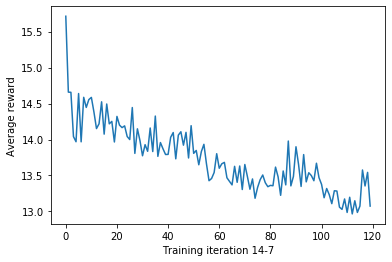

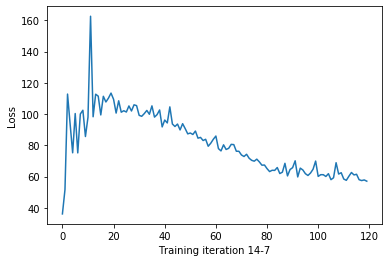

Generating molecules...: : 11it [00:06,  1.75it/s]                      
                                             

Mean value of predictions: 7.5400461857024705


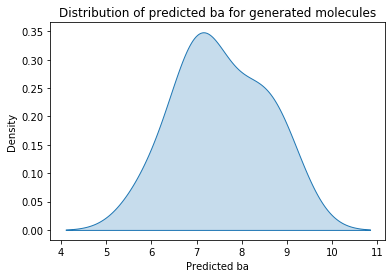

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

7th Sample trajectories:
CC(=O)NC1CCC(n2cc(C(N)=O)c(Nc3ccc(Cl)cc3)n2)C(C#N)C1
CC(C)(C#N)c1cnccc1NC(=O)c1cnn2cccnc12
CC(C)(C)C(=O)N1CCC(CC#N)(n2cc(C(N)=O)c(Nc3ccccc3)n2)CC1
CC1(Nc2ncc(C(N)=O)c3[nH]c4ccc(F)cc4c23)CN(CC(F)(F)F)C1=O
CCCS(=O)(=O)CC1CCCN(S(=O)(=O)CC2CCC(N(c3ncnc4[nH]ccc34)C(F)(F)F)CC2)C1
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

Policy gradient...:   7%|▋         | 1/15 [00:03<00:53,  3.80s/it]

0th cur_reward, cur_loss:  12.37575311849531 69.00260925292969



100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.20it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
Policy gradient...:  13%|█▎        | 2/15 [00:08<00:57,  4.45s/it]

1th cur_reward, cur_loss:  11.51883856715094 40.169429779052734



100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.20it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:15<01:07,  5.63s/it]

2th cur_reward, cur_loss:  14.42337362489576 44.773521423339844



100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.51it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [00:22<01:06,  6.08s/it]

3th cur_reward, cur_loss:  18.330623474199417 63.8095817565918



100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:28<01:00,  6.04s/it]

4th cur_reward, cur_loss:  12.916726063279246 59.076961517333984



100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                                             
Policy gradient...:  40%|████      | 6/15 [00:35<00:56,  6.28s/it]

5th cur_reward, cur_loss:  12.396814174806165 18.655216217041016



100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:41<00:50,  6.30s/it]

6th cur_reward, cur_loss:  13.495587646525385 22.969343185424805



100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.58it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:49<00:47,  6.85s/it]

7th cur_reward, cur_loss:  11.913336592850724 71.94180297851562



100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [00:56<00:41,  6.97s/it]

8th cur_reward, cur_loss:  13.616647480809496 49.42609786987305



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [01:05<00:36,  7.37s/it]

9th cur_reward, cur_loss:  15.88503954701567 50.39885330200195



100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [01:12<00:29,  7.31s/it]

10th cur_reward, cur_loss:  11.4230688523542 50.06630325317383



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [01:19<00:21,  7.24s/it]

11th cur_reward, cur_loss:  10.518036662040206 31.81182289123535



100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.26it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

12th cur_reward, cur_loss:  14.40252108231223 38.42089080810547



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:33<00:06,  6.89s/it]

13th cur_reward, cur_loss:  14.860580790079203 79.57682037353516



100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:38<00:00,  6.58s/it]


14th cur_reward, cur_loss:  14.407570991924516 22.35565185546875


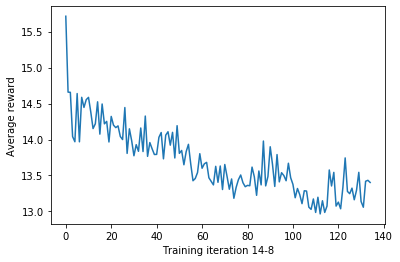

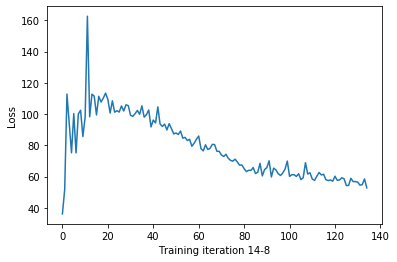

Generating molecules...: : 11it [00:08,  1.37it/s]                      


Mean value of predictions: 7.40167916847262


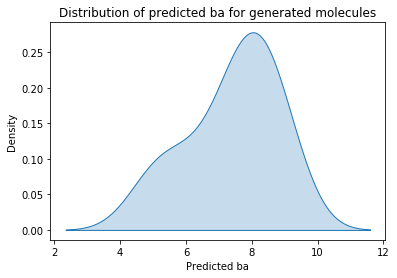

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

8th Sample trajectories:
CC(=O)N(C)C1CCN(c2ncnc3[nH]ccc23)C1
CC(=O)Nc1ccc(-c2ccnc(Nc3ccc(N4CCOCC4)cc3)n2)cc1
CC(C)(C#N)C(=O)N1CC(CC#N)(n2cc(C(N)=O)c(Nc3ccccc3)n2)C1
CC(C)(C)C(=O)c1cn(C2(CC#N)CCN(Cc3cccnc3)CC2)nc1Nc1ccnc(F)c1
CC1CCN(C(=O)C2CCCC2)CC1C(C)(C)C
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
Policy gradient...:   7%|▋         | 1/15 [00:06<01:31,  6.56s/it]

0th cur_reward, cur_loss:  10.997549383959724 27.311742782592773



100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.82it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
Policy gradient...:  13%|█▎        | 2/15 [00:09<01:01,  4.71s/it]

1th cur_reward, cur_loss:  12.379456927575948 45.00635528564453



100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:15<00:59,  4.96s/it]

2th cur_reward, cur_loss:  13.342564339069149 21.613210678100586



100%|██████████| 1/1 [00:00<00:00,  4.58it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [00:20<00:56,  5.17s/it]

3th cur_reward, cur_loss:  14.699173485270839 19.905839920043945



100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

4th cur_reward, cur_loss:  12.49790093208756 24.559911727905273



100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.15it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.67it/s]
                                             
Policy gradient...:  40%|████      | 6/15 [00:32<00:49,  5.48s/it]

5th cur_reward, cur_loss:  13.61280776333002 70.29470825195312



100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:37<00:42,  5.30s/it]

6th cur_reward, cur_loss:  14.483126003204656 20.836763381958008



100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:43<00:37,  5.29s/it]

7th cur_reward, cur_loss:  11.750109462074557 20.10946273803711



100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.75it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

8th cur_reward, cur_loss:  13.596782181118238 42.9226188659668



100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.57it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [00:55<00:28,  5.67s/it]

9th cur_reward, cur_loss:  11.653686906553846 13.441003799438477



100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [01:00<00:22,  5.50s/it]

10th cur_reward, cur_loss:  13.291896117787067 33.833343505859375



100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.75it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [01:05<00:15,  5.19s/it]

11th cur_reward, cur_loss:  11.403250345699663 16.55617332458496



100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.47it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [01:09<00:09,  4.86s/it]

12th cur_reward, cur_loss:  10.902811607223697 14.125110626220703



100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.28it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:16<00:05,  5.62s/it]

13th cur_reward, cur_loss:  14.023200151018452 64.7700424194336



100%|██████████| 1/1 [00:00<00:00,  4.82it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:21<00:00,  5.46s/it]


14th cur_reward, cur_loss:  8.330704322451629 24.708066940307617


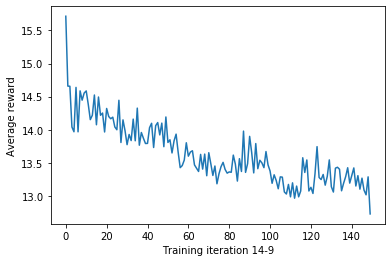

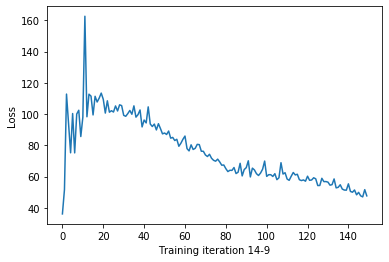

Generating molecules...: : 11it [00:04,  2.26it/s]                      


Mean value of predictions: 7.6590298873572085


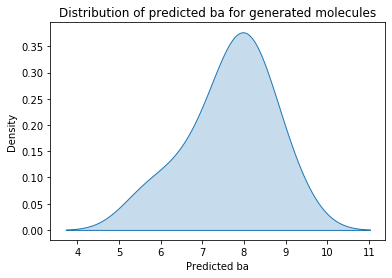

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

9th Sample trajectories:
CC(=O)N(c1ncnc2[nH]ccc12)C1CCC(CS(=O)(=O)N2CCCC(Cc3ccccn3)C2)CC1
CC(C)(C)[N+](C)([O-])C(=O)c1cn(C2COCCC2C#N)nc1Nc1ccc(-n2ccnn2)cc1
CC(C)NC(=O)c1c[nH]c2ncc(Nc3ccc(C=C(C#N)C(=O)C(C)(C)C)cc3)nc12
CC1(C)CC(c2cccnc2)N1
CN(C)C(=O)C(=O)c1cn(C2CCCCC2C#N)nc1Nc1ccc(F)c(F)c1
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.79it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  0%|          | 0/1 [00:00<?, ?it/s]

0th cur_reward, cur_loss:  16.583646339768563 85.58248901367188



100%|██████████| 1/1 [00:00<00:00,  3.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.17it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
Policy gradient...:  13%|█▎        | 2/15 [00:12<01:28,  6.82s/it]

1th cur_reward, cur_loss:  12.923951470843724 39.064998626708984



100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.83it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:16<01:02,  5.22s/it]

2th cur_reward, cur_loss:  13.75488493409895 16.26584243774414



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.57it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

3th cur_reward, cur_loss:  12.615064985933131 35.177974700927734



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:24<00:47,  4.80s/it]

4th cur_reward, cur_loss:  9.408900579929497 19.09242057800293



100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

5th cur_reward, cur_loss:  11.116060879612489 27.824228286743164



100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:34<00:38,  4.77s/it]

6th cur_reward, cur_loss:  13.458406179393457 47.8944206237793



100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.79it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:38<00:32,  4.63s/it]

7th cur_reward, cur_loss:  15.49482074304654 38.56500244140625



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

8th cur_reward, cur_loss:  19.357485469495096 39.521636962890625



100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [00:44<00:17,  3.56s/it]

9th cur_reward, cur_loss:  11.667748922054972 11.854314804077148



100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.79it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

10th cur_reward, cur_loss:  13.101745398740242 36.541481018066406



100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [00:55<00:14,  4.68s/it]

11th cur_reward, cur_loss:  14.062450330573927 34.1634635925293



100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.18it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [01:01<00:10,  5.13s/it]

12th cur_reward, cur_loss:  14.291795948999857 32.931739807128906



100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:06<00:04,  4.98s/it]

13th cur_reward, cur_loss:  12.800566444422298 27.197052001953125



100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.51it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:15<00:00,  5.04s/it]


14th cur_reward, cur_loss:  15.470108349861297 35.31800842285156


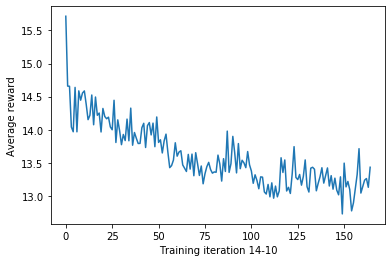

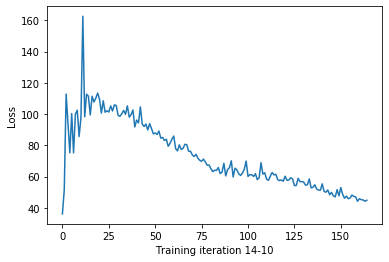

Generating molecules...: : 11it [00:14,  1.31s/it]                      


Mean value of predictions: 7.410228883900795


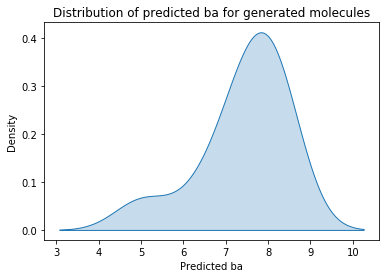

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

10th Sample trajectories:
CCC(C)(C)N(C)n1cc(C(N)=O)c(Nc2ccc(F)cc2)n1
CCC1CN(C(=O)C2(C#N)CC2)CC1Nc1c(C(=O)C(=O)N(C)C)cnn2cc(-c3ccnc(C)c3)nc12
CCN(C)C(C)(C=CC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1)C(C)(C)C
CN(C)C(=O)C1CCC(c2nnn3cnc4[nH]ccc4c23)CC1
CN(C)C(C)(C)COc1cc(-c2ccnc(Nc3ccc(N4CCOCC4)cc3)n2)ccc1C(=O)NCC#N
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.19it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  0%|          | 0/1 [00:00<?, ?it/s]

0th cur_reward, cur_loss:  16.790288174031954 64.92655181884766



100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

1th cur_reward, cur_loss:  14.754288274926276 74.46536254882812



100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.83it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:14<00:58,  4.91s/it]

2th cur_reward, cur_loss:  12.056819331966308 14.837647438049316



100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [00:18<00:52,  4.78s/it]

3th cur_reward, cur_loss:  13.35287422655281 27.757511138916016



100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.58it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:24<00:51,  5.11s/it]

4th cur_reward, cur_loss:  12.820557097904464 36.88615417480469



100%|██████████| 1/1 [00:00<00:00,  3.94it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

5th cur_reward, cur_loss:  12.457694508381614 45.47724914550781



100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:32<00:36,  4.61s/it]

6th cur_reward, cur_loss:  12.100410452499641 38.06138610839844



100%|██████████| 1/1 [00:00<00:00,  4.51it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.19it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:39<00:35,  5.08s/it]

7th cur_reward, cur_loss:  12.558598724149487 37.76516342163086



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.79it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

8th cur_reward, cur_loss:  13.567727666231617 25.86376190185547



100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [00:51<00:28,  5.67s/it]

9th cur_reward, cur_loss:  12.878643006292462 17.29265785217285



100%|██████████| 1/1 [00:00<00:00,  4.57it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [00:57<00:23,  5.96s/it]

10th cur_reward, cur_loss:  11.523543146418618 25.68944549560547



100%|██████████| 1/1 [00:00<00:00,  3.89it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

11th cur_reward, cur_loss:  11.317633498736027 10.371000289916992



100%|██████████| 1/1 [00:00<00:00,  4.20it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.20it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [01:13<00:14,  7.15s/it]

12th cur_reward, cur_loss:  12.507965627192755 34.67644119262695



100%|██████████| 1/1 [00:00<00:00,  4.81it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:21<00:07,  7.21s/it]

13th cur_reward, cur_loss:  14.80299128473824 31.478927612304688



100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:24<00:00,  5.67s/it]


14th cur_reward, cur_loss:  14.66313324710211 49.76999282836914


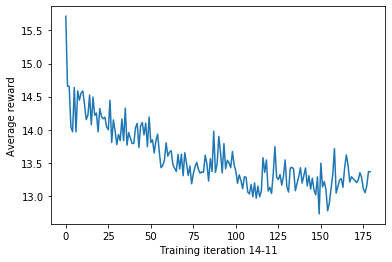

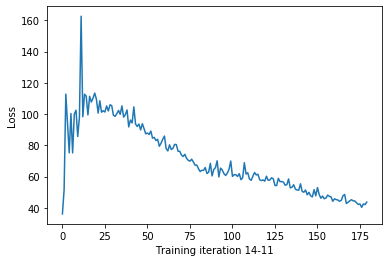

Generating molecules...: : 11it [00:11,  1.01s/it]                      


Mean value of predictions: 8.034762159319426


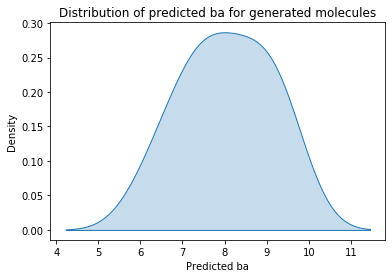

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

11th Sample trajectories:
CC(C)(C#N)Nc1cc(Cl)ccc1Cl
CC(C)(C)C(=O)NC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1
CC(C)(N=O)N(c1ccc(C#N)cc1)C1CCN(c2ncnc3[nH]ccc23)C1
CCS(=O)(=O)c1ccc(Nc2nn(C(C)(C)C)cc2C(N)=O)cc1
CN(C)C(=O)C(=O)c1cn(C2(CC#N)CCN(C(=O)OCCC(F)(F)F)CC2)nc1Nc1ccc(F)cc1
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.58it/s]
                                             
Policy gradient...:   7%|▋         | 1/15 [00:03<00:42,  3.02s/it]

0th cur_reward, cur_loss:  14.461712998576804 33.2326774597168



100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
Policy gradient...:  13%|█▎        | 2/15 [00:11<01:20,  6.16s/it]

1th cur_reward, cur_loss:  15.87944926428604 44.98600387573242



100%|██████████| 1/1 [00:00<00:00,  4.15it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.17it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

2th cur_reward, cur_loss:  11.15306484461558 20.05878448486328



100%|██████████| 1/1 [00:00<00:00,  3.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.85it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [00:17<00:44,  4.04s/it]

3th cur_reward, cur_loss:  16.558901652092565 14.357524871826172



100%|██████████| 1/1 [00:00<00:00,  4.67it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:23<00:48,  4.87s/it]

4th cur_reward, cur_loss:  9.782403976565998 16.589086532592773



100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

5th cur_reward, cur_loss:  12.933925504550896 15.167851448059082



100%|██████████| 1/1 [00:00<00:00,  4.58it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.50it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

6th cur_reward, cur_loss:  14.69373225027237 47.11371612548828



100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:39<00:37,  5.31s/it]

7th cur_reward, cur_loss:  11.655205805084567 21.429744720458984



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.82it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [00:44<00:31,  5.21s/it]

8th cur_reward, cur_loss:  12.220840607602977 9.659950256347656



100%|██████████| 1/1 [00:00<00:00,  4.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [00:49<00:26,  5.21s/it]

9th cur_reward, cur_loss:  14.059247542472326 27.125757217407227



100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

10th cur_reward, cur_loss:  17.5522399488765 12.059901237487793



100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.67it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [01:03<00:18,  6.16s/it]

11th cur_reward, cur_loss:  12.567892599064717 36.144954681396484



100%|██████████| 1/1 [00:00<00:00,  3.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.88it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

12th cur_reward, cur_loss:  11.627300670428111 20.326717376708984



100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

13th cur_reward, cur_loss:  14.664030960606333 27.313779830932617



100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.58it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.84it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:18<00:00,  5.23s/it]


14th cur_reward, cur_loss:  12.601338387443233 15.916282653808594


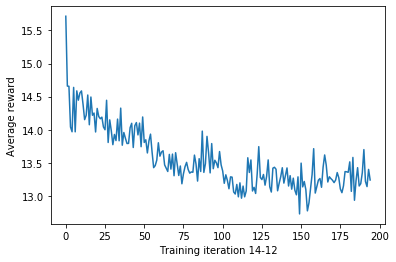

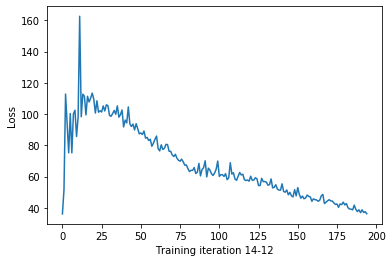

Generating molecules...: : 11it [00:05,  1.87it/s]                      


Mean value of predictions: 7.775580402661591


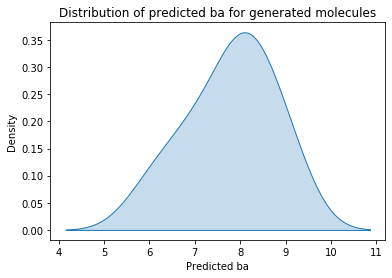

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

12th Sample trajectories:
CC(C)C(C)(C)CC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1
CC(C)C(N)(C(=O)c1ccc2[nH]nc(N)c2c1)N(C)C
CC(C)Oc1ccc(-c2cc3c(NC(C)(C)O)c(C(N)=O)cnn3c2)cn1
CC1CCN(N(C)C)CC1N(C)c1ncnc2[nH]ccc12
CCOC(=O)c1c[nH]c2ncnc(C(=O)N(C)C)c12
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.51it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.51it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                                             
Policy gradient...:   7%|▋         | 1/15 [00:03<00:44,  3.14s/it]

0th cur_reward, cur_loss:  11.987331108256049 47.12407684326172



100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                                             
Policy gradient...:  13%|█▎        | 2/15 [00:07<00:47,  3.63s/it]

1th cur_reward, cur_loss:  13.782813466858116 12.28331184387207



100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

2th cur_reward, cur_loss:  11.940720130306362 28.170642852783203



100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [00:13<00:34,  3.14s/it]

3th cur_reward, cur_loss:  17.83503223776818 10.604116439819336



100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.65it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:17<00:34,  3.49s/it]

4th cur_reward, cur_loss:  12.614397840864235 26.933643341064453



100%|██████████| 1/1 [00:00<00:00,  4.79it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
Policy gradient...:  40%|████      | 6/15 [00:20<00:31,  3.54s/it]

5th cur_reward, cur_loss:  8.334950320222204 13.117656707763672



100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

6th cur_reward, cur_loss:  13.098112514152163 11.42606258392334



100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.57it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

7th cur_reward, cur_loss:  11.426813346756665 34.20754623413086



100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [00:33<00:25,  4.19s/it]

8th cur_reward, cur_loss:  11.85086237366664 45.94894027709961



100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [00:39<00:23,  4.73s/it]

9th cur_reward, cur_loss:  12.974264804152956 36.49445724487305



100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

10th cur_reward, cur_loss:  9.685788114259177 15.14950942993164



100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [00:51<00:15,  5.33s/it]

11th cur_reward, cur_loss:  14.556423823752688 16.779447555541992



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.71it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

12th cur_reward, cur_loss:  11.581842364433447 44.773414611816406



100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.79it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:02<00:05,  5.34s/it]

13th cur_reward, cur_loss:  10.44007596619726 24.061994552612305



100%|██████████| 1/1 [00:00<00:00,  4.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:11<00:00,  4.74s/it]


14th cur_reward, cur_loss:  15.11438156573783 32.52372741699219


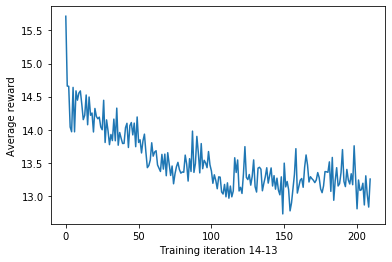

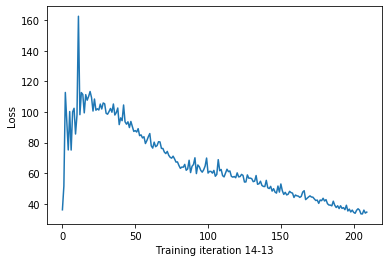

Generating molecules...: : 11it [00:02,  4.03it/s]                      


Mean value of predictions: 7.977300579001811


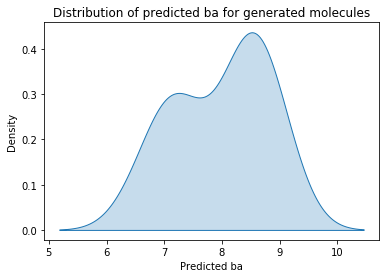

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

13th Sample trajectories:
CC(C)(C)c1ccnc(Nc2ccc(N3CCOCC3)cc2)n1
CC(N(C)C)C(C)(C#N)C(=O)c1cn(C2(CC#N)CCN(Cc3cccc4cc[nH]c34)CC2)nc1Nc1ccnc(F)c1
CN(C)C(C)(C)C1CC(NC#N)c2cc(-c3ncnc4[nH]ccc34)ccc21
CN(C)C1CCN(c2ncnc3[nH]ccc23)C1
CN(C)N1CCC(c2nnn3cnc4[nH]ccc4c23)CC1
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

0th cur_reward, cur_loss:  13.973449929020301 24.797658920288086



100%|██████████| 1/1 [00:00<00:00,  4.20it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.46it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

Policy gradient...:  13%|█▎        | 2/15 [00:10<01:07,  5.22s/it]

1th cur_reward, cur_loss:  11.635791661126355 24.149871826171875



100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.67it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

2th cur_reward, cur_loss:  10.347431127259783 33.983055114746094



100%|██████████| 1/1 [00:00<00:00,  3.88it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.79it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [00:18<00:49,  4.52s/it]

3th cur_reward, cur_loss:  14.990213358002114 28.12677001953125



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:23<00:46,  4.62s/it]

4th cur_reward, cur_loss:  18.545192207702705 31.323659896850586



100%|██████████| 1/1 [00:00<00:00,  3.81it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

5th cur_reward, cur_loss:  15.251273286384336 33.96226119995117



100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:31<00:35,  4.40s/it]

6th cur_reward, cur_loss:  11.628526705091657 31.874135971069336



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.82it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:35<00:30,  4.33s/it]

7th cur_reward, cur_loss:  12.56956548343025 31.909271240234375



100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.28it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

8th cur_reward, cur_loss:  11.274410613647722 17.931228637695312



100%|██████████| 1/1 [00:00<00:00,  3.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [00:46<00:23,  4.74s/it]

9th cur_reward, cur_loss:  14.996633500273662 21.89228057861328



100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [00:48<00:16,  4.11s/it]

10th cur_reward, cur_loss:  14.142023568448124 28.433147430419922



100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

11th cur_reward, cur_loss:  12.980462705011151 19.20911979675293



100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [00:59<00:09,  4.63s/it]

12th cur_reward, cur_loss:  15.610591121783452 14.121368408203125



100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

13th cur_reward, cur_loss:  15.076995970754501 64.30599212646484



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.84it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:05<00:00,  4.36s/it]


14th cur_reward, cur_loss:  14.623829704951103 10.70495891571045


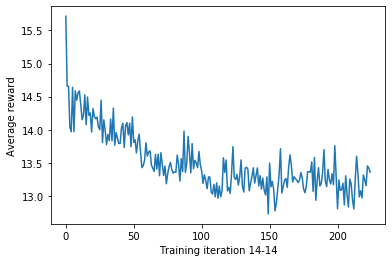

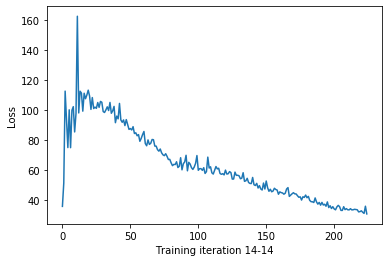

Generating molecules...: : 11it [00:05,  2.16it/s]                      


Mean value of predictions: 7.355233326045803


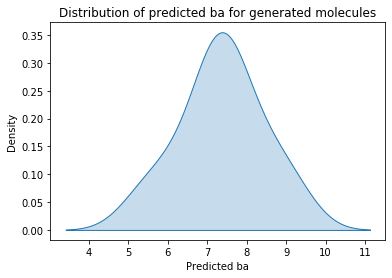

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

14th Sample trajectories:
CC(C)[N+](C)([O-])N1CCC(c2cccc(N(CCS(C)(=O)=O)c3nc4c(-c5ccc(P(C)(C)=O)cc5)cccn4n3)c2)CC1
CCC(N)S(=O)(=O)CC1CCC(N(C)c2ncnc3[nH]ccc23)CC1
CCC1CCC(CC#N)(n2cc(C(N)=O)c(Nc3ccnc(F)c3)n2)CC1
CN(C(=O)c1c[nH]c2ncc(Oc3ccc(C#N)cc3)nc12)C(=O)C(C)(C)C
CN(C)C(=O)c1cccc(Nc2nc(N)n(C(=O)c3c(F)cccc3F)n2)c1
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.78it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

  0%|          | 0/1 [00:00<?, ?it/s]

0th cur_reward, cur_loss:  13.960124131712453 33.48125457763672



100%|██████████| 1/1 [00:00<00:00,  3.77it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

1th cur_reward, cur_loss:  13.829034759577153 41.28010559082031



100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:14<00:54,  4.53s/it]

2th cur_reward, cur_loss:  13.780950479974953 20.600841522216797



100%|██████████| 1/1 [00:00<00:00,  4.51it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [00:19<00:53,  4.87s/it]

3th cur_reward, cur_loss:  13.047853996166106 15.042567253112793



100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:25<00:53,  5.32s/it]

4th cur_reward, cur_loss:  13.133863140997507 24.670602798461914



100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.75it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

5th cur_reward, cur_loss:  10.002184804516759 31.741743087768555



100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.17it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:35<00:39,  4.90s/it]

6th cur_reward, cur_loss:  13.040415091244567 18.834423065185547



100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

7th cur_reward, cur_loss:  14.025106988188496 9.294775009155273



100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.58it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [00:45<00:28,  4.72s/it]

8th cur_reward, cur_loss:  11.64930844109328 26.384883880615234



100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.75it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

9th cur_reward, cur_loss:  9.065260064964482 5.908795356750488



100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.79it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [00:51<00:15,  3.76s/it]

10th cur_reward, cur_loss:  12.175960342017456 17.28700828552246



100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.74it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

11th cur_reward, cur_loss:  11.30611047755601 39.62961959838867



100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [01:00<00:07,  3.99s/it]

12th cur_reward, cur_loss:  16.75741070412651 32.67434310913086



100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.12it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:03<00:03,  3.64s/it]

13th cur_reward, cur_loss:  12.289926764017517 16.867233276367188



100%|██████████| 1/1 [00:00<00:00,  3.92it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.26it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:07<00:00,  4.52s/it]


14th cur_reward, cur_loss:  13.603344348077389 48.72474670410156


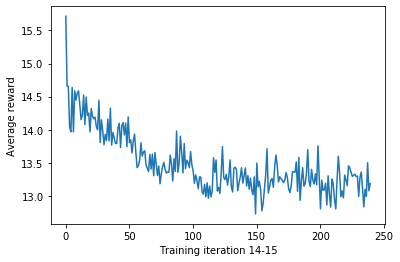

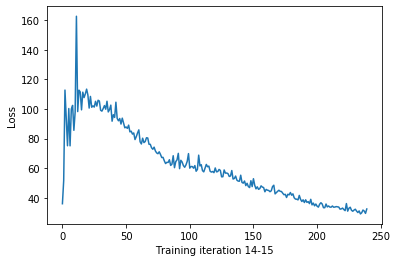

Generating molecules...: : 11it [00:03,  2.84it/s]                      


Mean value of predictions: 7.289675647225264


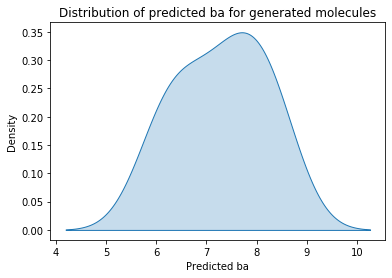

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

15th Sample trajectories:
CC(C)(C)[N+]([O-])(Nc1ccc(CNc2cc(Nc3ccc(N4CCOCC4)cc3)ncn2)cc1)C(C)(C)N=O
CC(C)C(=O)NC1CCCN(S(C)(=O)=O)C1
CC1CC(NC(=O)Nc2cnc3[nH]ccc3n2)CN(C)C1
CC1CCN(C(C)(C)C)CC1c1nnn2cnc3[nH]ccc3c12
CN(C)C(=O)C1CCC(c2nnn3cnc4[nH]ccc4c23)CC1
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

0th cur_reward, cur_loss:  11.554023613078002 13.971305847167969



100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                                             
Policy gradient...:  13%|█▎        | 2/15 [00:07<00:51,  3.92s/it]

1th cur_reward, cur_loss:  15.045200235545744 23.217632293701172



100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.67it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:17<01:16,  6.39s/it]

2th cur_reward, cur_loss:  12.130084246102463 33.191612243652344



100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.79it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [00:20<00:56,  5.10s/it]

3th cur_reward, cur_loss:  11.8036446258089 15.973078727722168



100%|██████████| 1/1 [00:00<00:00,  4.79it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.94it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:27<00:56,  5.68s/it]

4th cur_reward, cur_loss:  11.016350794753798 12.282371520996094



100%|██████████| 1/1 [00:00<00:00,  4.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
Policy gradient...:  40%|████      | 6/15 [00:30<00:45,  5.09s/it]

5th cur_reward, cur_loss:  12.395893144661827 11.460223197937012



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.67it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:36<00:40,  5.10s/it]

6th cur_reward, cur_loss:  15.479776618233796 13.14205551147461



100%|██████████| 1/1 [00:00<00:00,  4.75it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:39<00:32,  4.69s/it]

7th cur_reward, cur_loss:  12.06815377097277 13.640251159667969



100%|██████████| 1/1 [00:00<00:00,  4.79it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

8th cur_reward, cur_loss:  12.222167410746017 29.50153350830078



100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.74it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

9th cur_reward, cur_loss:  13.519773174720381 38.469154357910156



100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.92it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.53it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [00:55<00:18,  4.63s/it]

10th cur_reward, cur_loss:  10.869443689910387 17.085134506225586



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.60it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [00:59<00:13,  4.58s/it]

11th cur_reward, cur_loss:  13.379033594158642 26.954763412475586



100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.82it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.75it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [01:03<00:08,  4.25s/it]

12th cur_reward, cur_loss:  14.626978401256565 13.1536865234375



100%|██████████| 1/1 [00:00<00:00,  4.20it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:07<00:04,  4.13s/it]

13th cur_reward, cur_loss:  11.989989986936617 20.223142623901367



100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.18it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:10<00:00,  4.69s/it]


14th cur_reward, cur_loss:  11.00390093424378 22.29751968383789


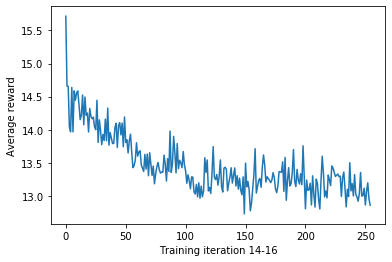

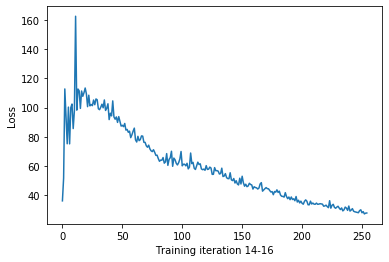

Generating molecules...: : 11it [00:03,  3.41it/s]                      


Mean value of predictions: 7.825220122640266


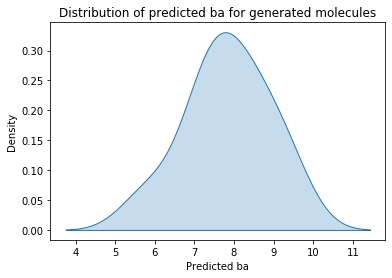

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

16th Sample trajectories:
CC(C)(C)C(=O)C1CCC(c2nnn3cnc4[nH]ccc4c23)CC1
CC(C)(C)Nc1cc(-c2ccoc2)nc(-n2cnc3ccc(C#N)cc32)n1
CC(C)(C)n1c(=O)[nH]c2cnc(-c3cnc4ccc(F)cn34)nc21
CCN(C)C(=O)N1CCC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2)C(C#N)C1
CCN(C)C1CCC(c2nnn3cnc4[nH]ccc4c23)CC1
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.20it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

Policy gradient...:   7%|▋         | 1/15 [00:05<01:22,  5.89s/it]

0th cur_reward, cur_loss:  11.496226896795203 38.70048522949219



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.67it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

1th cur_reward, cur_loss:  14.686058984581223 28.636947631835938



100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.50it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:16<01:02,  5.22s/it]

2th cur_reward, cur_loss:  11.06134384135258 36.91770935058594



100%|██████████| 1/1 [00:00<00:00,  4.67it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.75it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

3th cur_reward, cur_loss:  11.181198016800149 14.924402236938477



100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.22it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:26<00:51,  5.16s/it]

4th cur_reward, cur_loss:  7.168534902324575 12.091063499450684



100%|██████████| 1/1 [00:00<00:00,  4.51it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.15it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.12it/s]
                                             
Policy gradient...:  40%|████      | 6/15 [00:35<00:57,  6.43s/it]

5th cur_reward, cur_loss:  12.575694088993728 16.34514617919922



100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

6th cur_reward, cur_loss:  10.615369331874552 37.50908660888672



100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.96it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:40<00:31,  4.49s/it]

7th cur_reward, cur_loss:  13.631297638776104 52.7476806640625



100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.67it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.19it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [00:51<00:37,  6.32s/it]

8th cur_reward, cur_loss:  10.112868123553682 21.975093841552734



100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

9th cur_reward, cur_loss:  10.324852217032625 6.623952388763428



100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [01:03<00:24,  6.13s/it]

10th cur_reward, cur_loss:  13.637253167658915 18.398357391357422



100%|██████████| 1/1 [00:00<00:00,  3.77it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

11th cur_reward, cur_loss:  10.861439387431606 44.89098358154297



100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.57it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [01:10<00:09,  4.73s/it]

12th cur_reward, cur_loss:  11.341662597659434 18.467626571655273



100%|██████████| 1/1 [00:00<00:00,  4.12it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:13<00:04,  4.27s/it]

13th cur_reward, cur_loss:  13.323777448493354 15.86265754699707



100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:17<00:00,  5.19s/it]


14th cur_reward, cur_loss:  14.381186177439233 11.735408782958984


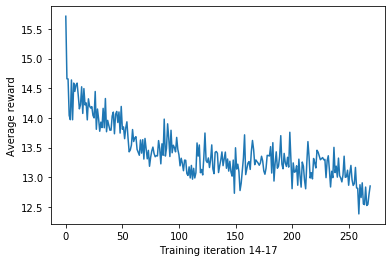

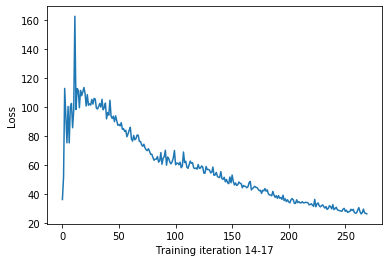

Generating molecules...: : 11it [00:09,  1.11it/s]                      


Mean value of predictions: 7.1571830771633485


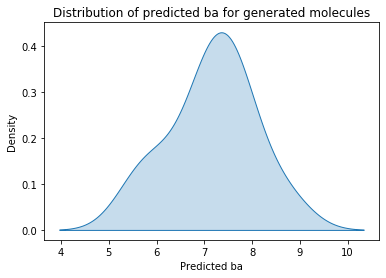

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

17th Sample trajectories:
CC(=O)N(C)n1cc(C(N)=O)c(Nc2ccnc(F)c2)n1
CC(C)(C)C(=O)C(=O)NN1CC(CC#N)(n2cc(C(N)=O)c(Nc3ccccc3)n2)C1
CC(C)(C)C(C)(C)N1CCC(CC#N)(n2cc(C(N)=O)c(Nc3ccccc3)n2)CC1
CC(C)(C)N=c1sccn1Cc1cccc2ccccc12
CN(C)C(=O)C(=O)c1cn(C2CCCCC2C#N)nc1Nc1cc(F)cc(Cl)c1
###################################################################



100%|██████████| 1/1 [00:00<00:00,  3.70it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  4.19it/s]
                                             
Policy gradient...:   7%|▋         | 1/15 [00:08<01:54,  8.18s/it]

0th cur_reward, cur_loss:  13.739790252882983 36.05127716064453



100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.59it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.96it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

1th cur_reward, cur_loss:  12.907162983217296 33.14875030517578



100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

2th cur_reward, cur_loss:  9.75505200988805 32.760005950927734



100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

3th cur_reward, cur_loss:  13.949935162401896 22.229686737060547



100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:27<00:59,  5.97s/it]

4th cur_reward, cur_loss:  13.072996900535752 30.217618942260742



100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

5th cur_reward, cur_loss:  13.860312938464892 20.20203971862793



100%|██████████| 1/1 [00:00<00:00,  3.96it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.96it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

6th cur_reward, cur_loss:  14.06846089065846 32.543941497802734



100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.15it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:54<00:55,  7.87s/it]

7th cur_reward, cur_loss:  11.185207253067695 21.895444869995117



100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.20it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

8th cur_reward, cur_loss:  13.283980798749274 10.88594913482666



100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [01:04<00:30,  6.16s/it]

9th cur_reward, cur_loss:  13.42596900055741 33.55540084838867



100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [01:10<00:24,  6.13s/it]

10th cur_reward, cur_loss:  11.825390634754775 14.955044746398926



100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.58it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [01:19<00:20,  6.84s/it]

11th cur_reward, cur_loss:  10.527349662706888 33.408477783203125



100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.85it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

12th cur_reward, cur_loss:  15.041570114201079 51.86796951293945



100%|██████████| 1/1 [00:00<00:00,  3.79it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.94it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.61it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

13th cur_reward, cur_loss:  12.552797789093635 49.892032623291016



100%|██████████| 1/1 [00:00<00:00,  3.84it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.94it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.72it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:29<00:00,  5.98s/it]


14th cur_reward, cur_loss:  11.417516394239756 17.67076301574707


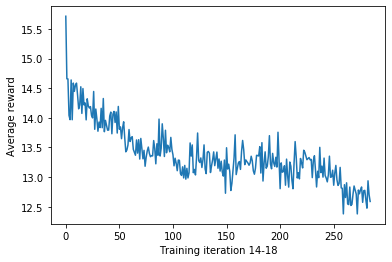

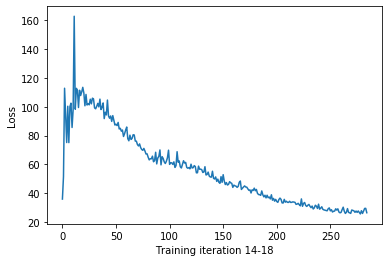

Generating molecules...: : 11it [00:06,  1.62it/s]                      


Mean value of predictions: 7.8584180004922946


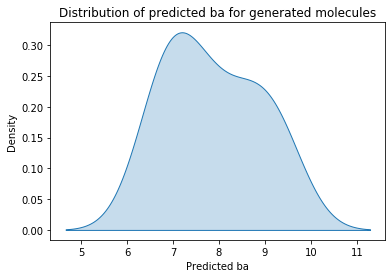

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

18th Sample trajectories:
CC(C)[N+](C)([O-])N(c1ccccc1CNc1cccn2nc(Nc3ccc4cnccc4c3)nc12)S(C)(=O)=O
CC(N1CCCC12CCCN(c1ncnc3nc[nH]c13)C2)C(C)(C)C
CC1(C#N)CCC1(N)n1c(=O)[nH]c2cnc3[nH]ccc3c21
CN(C)C(=O)C1CC(CCNC2CCC(CC#N)(n3cc(C(N)=O)c(Nc4ccc(F)cc4)n3)CC2)C1
CN(C)C(=O)N(C)CCC(=O)c1cn(C2(CC#N)CCN(Cc3ccc(O)nc3)CC2)nc1Nc1ccnc(F)c1
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.51it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.57it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

0th cur_reward, cur_loss:  13.552980955248637 13.809308052062988



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
Policy gradient...:  13%|█▎        | 2/15 [00:09<01:04,  4.94s/it]

1th cur_reward, cur_loss:  9.528620348011572 11.620361328125



100%|██████████| 1/1 [00:00<00:00,  4.17it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:12<00:51,  4.32s/it]

2th cur_reward, cur_loss:  12.991127508490262 46.92631530761719



100%|██████████| 1/1 [00:00<00:00,  4.50it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.57it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

3th cur_reward, cur_loss:  17.186222385664678 48.474910736083984



100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

4th cur_reward, cur_loss:  9.799156359857264 14.025075912475586



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

5th cur_reward, cur_loss:  14.139296330923333 28.125385284423828



100%|██████████| 1/1 [00:00<00:00,  3.84it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:31<00:36,  4.55s/it]

6th cur_reward, cur_loss:  14.569492201442362 51.52819061279297



100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:36<00:34,  4.88s/it]

7th cur_reward, cur_loss:  13.705456619140113 18.005109786987305



100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.22it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [00:40<00:26,  4.49s/it]

8th cur_reward, cur_loss:  7.630986568137594 24.789417266845703



100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.96it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

9th cur_reward, cur_loss:  13.780095180876483 16.54091453552246



100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

10th cur_reward, cur_loss:  12.385103032723265 9.482514381408691



100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

11th cur_reward, cur_loss:  12.525361981115458 25.913589477539062



100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.84it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [01:01<00:09,  4.74s/it]

12th cur_reward, cur_loss:  13.19407495290227 20.225793838500977



100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.73it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.84it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.22it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:07<00:05,  5.18s/it]

13th cur_reward, cur_loss:  13.251031648901126 15.792067527770996



100%|██████████| 1/1 [00:00<00:00,  3.57it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.29it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:11<00:00,  4.73s/it]

14th cur_reward, cur_loss:  10.483476664398609 46.177886962890625


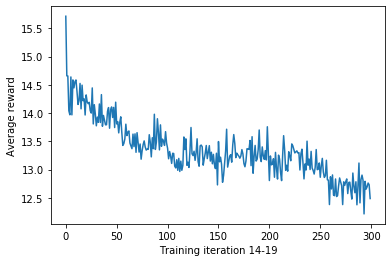

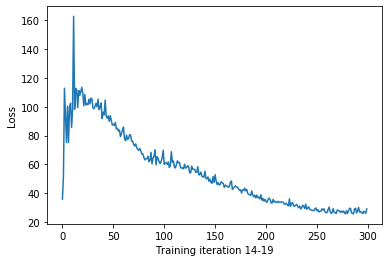

Generating molecules...: : 11it [00:05,  2.08it/s]                      


Mean value of predictions: 7.551788812627142


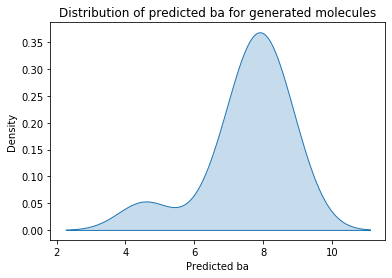

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

19th Sample trajectories:
CC(C)(C)CC(NC(=O)c1cc2[nH]nc(NC(=O)c3ccc(N4CCOCC4)cc3)c2s1)c1ccccc1
CCC(=O)n1c(C(=O)N(C2CC2)C2CC2)cc2c3c(ncn3C)c(NC)nc21
CCN(C)C(=O)OCCn1cc(-c2nn(CC3CCN(C(=O)CC#N)CC3)c3ncnc(N)c23)cn1
CCN1CN(C2CCC(CC(C)(C)C)CC2)c2c(cnc3[nH]ccc23)C1=O
CN(C)C(=O)CCCC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  3.77it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.87it/s]
                                             
Policy gradient...:   7%|▋         | 1/15 [00:02<00:38,  2.77s/it]

0th cur_reward, cur_loss:  12.670349897681714 28.379955291748047



100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

1th cur_reward, cur_loss:  13.583178991582523 32.46554183959961



100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:13<00:55,  4.65s/it]

2th cur_reward, cur_loss:  15.821969768446735 5.850253582000732



100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.77it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

3th cur_reward, cur_loss:  11.337231928870287 10.201457023620605



100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

4th cur_reward, cur_loss:  13.923759125648525 12.518972396850586



100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

5th cur_reward, cur_loss:  13.727940692159057 28.419631958007812



100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.54it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:31<00:36,  4.51s/it]

6th cur_reward, cur_loss:  11.569419887842297 10.323966979980469



100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.46it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:33<00:27,  3.96s/it]

7th cur_reward, cur_loss:  14.151233174179787 19.409820556640625



100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [00:38<00:24,  4.04s/it]

8th cur_reward, cur_loss:  12.468295050197133 12.75406551361084



100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [00:43<00:21,  4.34s/it]

9th cur_reward, cur_loss:  10.406993280501792 12.997953414916992



100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.28it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

10th cur_reward, cur_loss:  11.065907791321916 14.763312339782715



100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [00:53<00:13,  4.51s/it]

11th cur_reward, cur_loss:  10.66629339420054 18.49411392211914



100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [00:57<00:08,  4.41s/it]

12th cur_reward, cur_loss:  12.5728907448907 12.662738800048828



100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.85it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:02<00:04,  4.73s/it]

13th cur_reward, cur_loss:  16.562636320364955 45.393062591552734



100%|██████████| 1/1 [00:00<00:00,  3.96it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:07<00:00,  4.51s/it]


14th cur_reward, cur_loss:  11.997904531835058 12.982338905334473


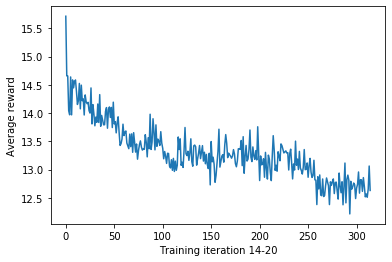

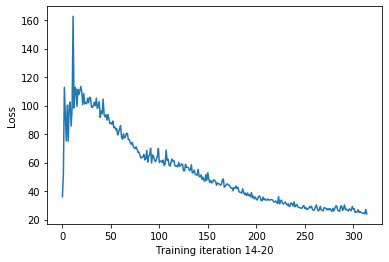

Generating molecules...: : 11it [00:07,  1.40it/s]                      


Mean value of predictions: 7.71113141581524


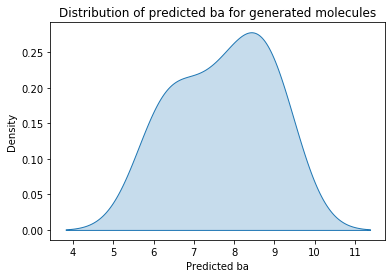

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

20th Sample trajectories:
CC(=O)N1CC(CC#N)(n2cc(C(N)=O)c(Nc3ccccc3)n2)C1
CC(=O)N1CCCC12CCCN(c1ncnc3[nH]ccc13)C2
CC(=O)N1CCN(c2nc(Nc3cc(C)[nH]n3)c3cccn3n2)CC1
CC(C)(C)N1CCC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2)C(C#N)C1
CC(C)NC1CCCN(c2ccc(C(F)(F)F)c(C3=C(c4c[nH]c5ccccc45)C(=O)NC3=O)c2)C1
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                                             
Policy gradient...:   7%|▋         | 1/15 [00:03<00:49,  3.53s/it]

0th cur_reward, cur_loss:  11.466454898427894 26.506484985351562



100%|██████████| 1/1 [00:00<00:00,  3.55it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.92it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.71it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.80it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

  0%|          | 0/1 [00:00<?, ?it/s]

1th cur_reward, cur_loss:  11.932291150913187 12.713359832763672



100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:13<00:49,  4.14s/it]

2th cur_reward, cur_loss:  16.216049828697617 13.932042121887207



100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [00:16<00:41,  3.78s/it]

3th cur_reward, cur_loss:  9.84798098975233 19.962621688842773



100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

4th cur_reward, cur_loss:  10.326035165050467 35.91238784790039



100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

5th cur_reward, cur_loss:  11.354384458952936 16.184255599975586



100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:30<00:36,  4.59s/it]

6th cur_reward, cur_loss:  12.723837957162855 14.925149917602539



100%|██████████| 1/1 [00:00<00:00,  3.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:33<00:27,  3.98s/it]

7th cur_reward, cur_loss:  9.116390803273168 11.320148468017578



100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

8th cur_reward, cur_loss:  14.628588125090015 40.21675109863281



100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

9th cur_reward, cur_loss:  11.643896965596701 14.444682121276855



100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [00:54<00:24,  6.10s/it]

10th cur_reward, cur_loss:  11.268185972772285 70.73263549804688



100%|██████████| 1/1 [00:00<00:00,  3.94it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.84it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [01:00<00:18,  6.09s/it]

11th cur_reward, cur_loss:  12.251107090320176 15.877534866333008



100%|██████████| 1/1 [00:00<00:00,  3.82it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.20it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

12th cur_reward, cur_loss:  13.226598173763454 26.666837692260742



100%|██████████| 1/1 [00:00<00:00,  4.51it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:08<00:05,  5.06s/it]

13th cur_reward, cur_loss:  11.125230976703994 31.406965255737305



100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:14<00:00,  4.95s/it]


14th cur_reward, cur_loss:  12.89445285730824 22.972097396850586


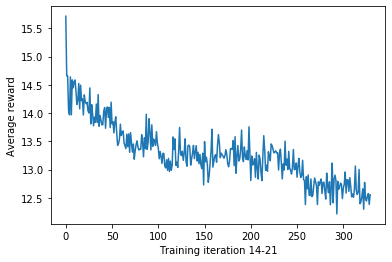

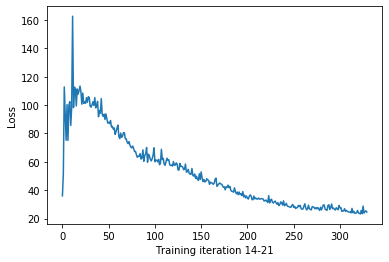

Generating molecules...: : 11it [00:12,  1.16s/it]                      
                                             

Mean value of predictions: 7.427747697649323


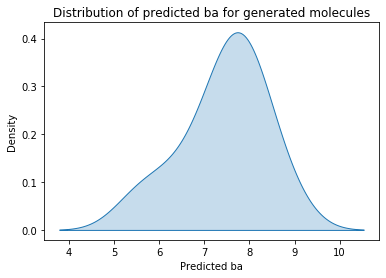

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

21th Sample trajectories:
CC(C)N(CCOc1ccc(-c2oc3nccc(NCCN4CCNCC4)c3c2N(C(C)C)C(C)(C)C)cc1)C(C)C
CC=CCOCCC(=O)N1CCCC12CCCN(c1ncnc3[nH]ccc13)C2
CCC(C)(CCC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1)N(C)C
CN(C)C(=O)CC(=O)N1CCC(CC#N)(n2cc(C(N)=O)c(Nc3ccc(C4CC4)nc3)n2)CC1
CN(C)C1CCC(n2cc(C(=O)C(C)(C)C)c(Nc3ccc(Cl)cc3)n2)C(C#N)C1
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
Policy gradient...:   7%|▋         | 1/15 [00:05<01:11,  5.07s/it]

0th cur_reward, cur_loss:  18.261117858881896 24.43990135192871



100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
Policy gradient...:  13%|█▎        | 2/15 [00:10<01:09,  5.32s/it]

1th cur_reward, cur_loss:  7.146547834857991 21.518369674682617



100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:16<01:07,  5.61s/it]

2th cur_reward, cur_loss:  13.799699063311186 20.071868896484375



100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

3th cur_reward, cur_loss:  12.96782105582796 25.307958602905273



100%|██████████| 1/1 [00:00<00:00,  3.65it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.81it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:27<00:54,  5.47s/it]

4th cur_reward, cur_loss:  11.604508908949844 7.542609214782715



100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

5th cur_reward, cur_loss:  12.114878336066505 27.438400268554688



100%|██████████| 1/1 [00:00<00:00,  4.18it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:38<00:42,  5.34s/it]

6th cur_reward, cur_loss:  13.380756617360362 57.7140998840332



100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:45<00:40,  5.77s/it]

7th cur_reward, cur_loss:  12.152954707078225 35.651939392089844



100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [00:49<00:31,  5.30s/it]

8th cur_reward, cur_loss:  12.497175939493053 28.281736373901367



100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [00:57<00:30,  6.08s/it]

9th cur_reward, cur_loss:  14.471607973160195 15.947339057922363



100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.84it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [01:03<00:23,  5.91s/it]

10th cur_reward, cur_loss:  14.88612024730494 39.61160659790039



100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

11th cur_reward, cur_loss:  12.412390447520814 13.678214073181152



100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.22it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.46it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

12th cur_reward, cur_loss:  8.03714399513635 24.538633346557617



100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:16<00:04,  4.86s/it]

13th cur_reward, cur_loss:  9.65156995892977 18.197805404663086



100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:20<00:00,  5.34s/it]


14th cur_reward, cur_loss:  12.055093910767335 28.892770767211914


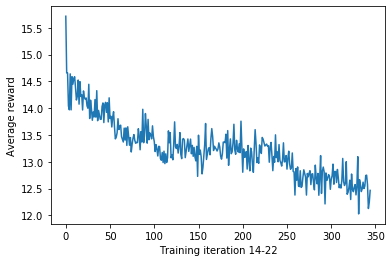

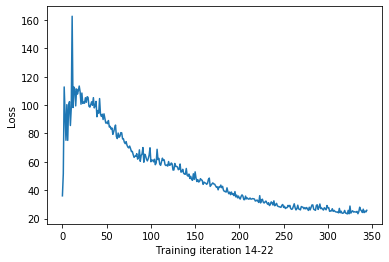

Generating molecules...: : 11it [00:08,  1.29it/s]                      


Mean value of predictions: 7.826562832509396


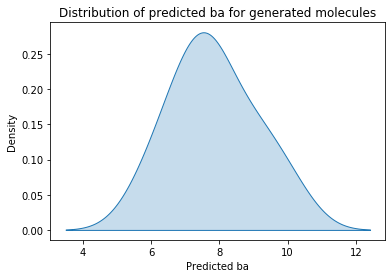

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

22th Sample trajectories:
CC(CC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1)C(=O)N(C)C
CCC=Cc1ccc(Nc2cnc3[nH]cc(C(=O)C(C)(C)C)c3n2)cc1
CCN(C)C(=O)C1CCN(c2cc(-c3cnc4ccc(N5CCCC5c5cccc(F)c5)nn34)ccn2)CC1
CN(C)C(=O)S(=O)(=O)c1cc(Cl)c(Nc2nc3ccncc3c3c(=O)[nH]ccc23)c(Cl)c1
CN(C)C(=O)c1cc(Cl)ccc1O
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  4.50it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
                                             
Policy gradient...:   7%|▋         | 1/15 [00:05<01:10,  5.03s/it]

0th cur_reward, cur_loss:  14.848300703232086 25.621807098388672



100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.83it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

1th cur_reward, cur_loss:  10.137365738905872 25.711400985717773



100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:15<01:01,  5.15s/it]

2th cur_reward, cur_loss:  10.66012121064145 5.630063533782959



100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

3th cur_reward, cur_loss:  19.190335257662152 56.151458740234375



100%|██████████| 1/1 [00:00<00:00,  4.19it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.59it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:22<00:40,  4.08s/it]

4th cur_reward, cur_loss:  13.962054721589215 12.546008110046387



100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
Policy gradient...:  40%|████      | 6/15 [00:29<00:43,  4.80s/it]

5th cur_reward, cur_loss:  15.874847328576053 24.876548767089844



100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.72it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:34<00:39,  4.92s/it]

6th cur_reward, cur_loss:  9.668495744609805 17.94011688232422



100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.86it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

7th cur_reward, cur_loss:  12.558921064354692 28.012901306152344



100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

8th cur_reward, cur_loss:  16.67938196288686 15.992103576660156



100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [00:52<00:29,  5.82s/it]

9th cur_reward, cur_loss:  13.252391667307355 31.310026168823242



100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [00:57<00:22,  5.67s/it]

10th cur_reward, cur_loss:  12.662819914016461 41.99588394165039



100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.22it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.58it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

11th cur_reward, cur_loss:  11.158556495030561 15.73277759552002



100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

12th cur_reward, cur_loss:  12.608187017693954 30.386032104492188



100%|██████████| 1/1 [00:00<00:00,  4.57it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.58it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:09<00:04,  4.64s/it]

13th cur_reward, cur_loss:  14.842232938304699 35.46470260620117



100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:14<00:00,  4.99s/it]


14th cur_reward, cur_loss:  17.32918883696862 25.786252975463867


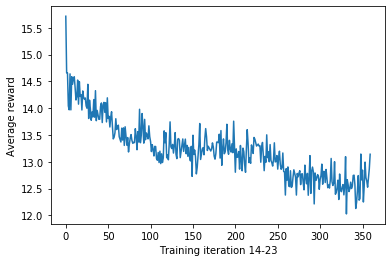

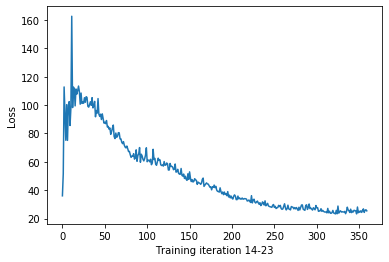

Generating molecules...: : 11it [00:02,  3.80it/s]                      


Mean value of predictions: 7.31322586607831


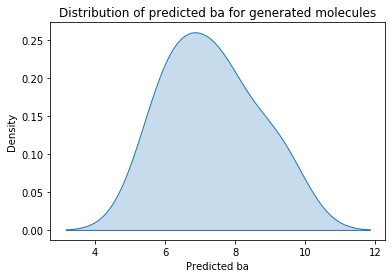

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

23th Sample trajectories:
CN(C)C1CCN(c2ccc(Nc3nc4c(-c5ccc(S(C)(=O)=O)cc5)cccn4n3)cc2)CC1
CN(C)CCC1CCC(n2cc(C(N)=O)c(Nc3ccc(S(=O)(=O)C(F)(F)F)cc3)n2)C(C#N)C1
CN(C)Oc1ccc(CNCC2CCC(c3nnn4cnc5[nH]ccc5c34)CC2)cc1
CN(CC(=O)c1cc(N(C)S(C)(=O)=O)c2cn[nH]c2c1)C(C)(C)C
CN(CC(C)(C)C)n1cc(C(N)=O)c(Nc2ccnc(F)c2)n1
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  0%|          | 0/1 [00:00<?, ?it/s]

0th cur_reward, cur_loss:  11.741449814634313 39.434425354003906



100%|██████████| 1/1 [00:00<00:00,  3.88it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
Policy gradient...:  13%|█▎        | 2/15 [00:09<01:01,  4.73s/it]

1th cur_reward, cur_loss:  14.28690116941006 27.995891571044922



100%|██████████| 1/1 [00:00<00:00,  3.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.79it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.85it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:14<01:01,  5.11s/it]

2th cur_reward, cur_loss:  14.555554734136477 11.147226333618164



100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [00:19<00:53,  4.88s/it]

3th cur_reward, cur_loss:  11.10025488282857 13.019952774047852



100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.17it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

4th cur_reward, cur_loss:  14.775319931485544 15.603784561157227



100%|██████████| 1/1 [00:00<00:00,  3.92it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

5th cur_reward, cur_loss:  11.199216528843976 28.430818557739258



100%|██████████| 1/1 [00:00<00:00,  3.53it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.87it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

6th cur_reward, cur_loss:  11.460144089631106 12.4280424118042



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:35<00:27,  3.90s/it]

7th cur_reward, cur_loss:  9.183580466546868 7.636470317840576



100%|██████████| 1/1 [00:00<00:00,  3.73it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.53it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.82it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.82it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [00:39<00:24,  4.08s/it]

8th cur_reward, cur_loss:  10.884815954138066 25.38903045654297



100%|██████████| 1/1 [00:00<00:00,  3.55it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.58it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [00:43<00:20,  4.05s/it]

9th cur_reward, cur_loss:  10.731729950296485 15.661871910095215



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.92it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [00:48<00:16,  4.07s/it]

10th cur_reward, cur_loss:  15.951578010816336 12.57148265838623



100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.88it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

11th cur_reward, cur_loss:  14.430350184873129 15.03061580657959



100%|██████████| 1/1 [00:00<00:00,  3.83it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.82it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [00:56<00:08,  4.07s/it]

12th cur_reward, cur_loss:  13.747062993068884 26.11128807067871



100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:04<00:05,  5.23s/it]

13th cur_reward, cur_loss:  13.062707246139993 37.876461029052734



100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:08<00:00,  4.58s/it]


14th cur_reward, cur_loss:  16.40397287678079 41.27671813964844


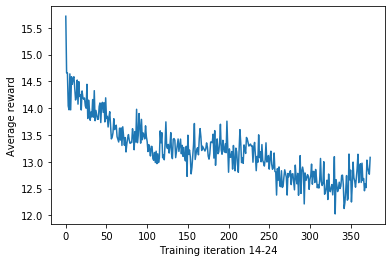

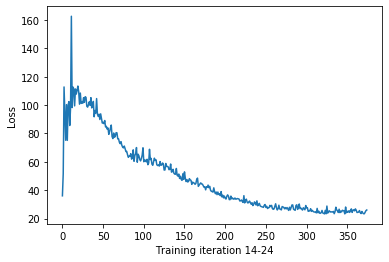

Generating molecules...: : 11it [00:07,  1.40it/s]                      


Mean value of predictions: 7.462596741664656


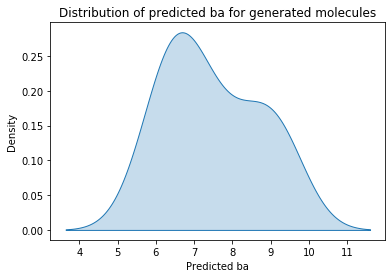

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

24th Sample trajectories:
CC(C)(N=O)n1cnc2c(Nc3ccc(F)cc3)nc(NCc3ccc(C4CCCCC4)cc3)nc21
CCC(=O)C1CCN(S(=O)(=O)CC)C1
CCC(C)(C(=O)c1cn(C2(CC#N)CCN(c3ccnc(OC)c3)CC2)nc1Nc1ccc(F)cc1)N(C)C
CCCN1CCCCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1
CCOC(=O)c1c[nH]c2ncnc(C(=O)C(C)(C)N(C)C)c12
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  3.92it/s]
                                             
Policy gradient...:   7%|▋         | 1/15 [00:06<01:27,  6.27s/it]

0th cur_reward, cur_loss:  12.112181429135717 4.069711208343506



100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.26it/s]
                                             
Policy gradient...:  13%|█▎        | 2/15 [00:11<01:17,  5.95s/it]

1th cur_reward, cur_loss:  12.56313714930605 15.641416549682617



100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.18it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:16<01:03,  5.32s/it]

2th cur_reward, cur_loss:  13.521813284186436 27.115079879760742



100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [00:21<00:55,  5.01s/it]

3th cur_reward, cur_loss:  11.791214878676792 11.63788890838623



100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:26<00:52,  5.25s/it]

4th cur_reward, cur_loss:  15.825300008459353 49.580318450927734



100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.87it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.60it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                                             
Policy gradient...:  40%|████      | 6/15 [00:29<00:38,  4.27s/it]

5th cur_reward, cur_loss:  16.047926599829896 15.03771686553955



100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.51it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:33<00:33,  4.15s/it]

6th cur_reward, cur_loss:  11.314937431236752 22.324800491333008



100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:38<00:31,  4.57s/it]

7th cur_reward, cur_loss:  10.897651084143767 9.817583084106445



100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [00:47<00:35,  5.89s/it]

8th cur_reward, cur_loss:  13.580776069423681 11.162856101989746



100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.12it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.26it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

9th cur_reward, cur_loss:  10.846967517874285 9.513548851013184



100%|██████████| 1/1 [00:00<00:00,  3.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.96it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

10th cur_reward, cur_loss:  10.623074965300615 8.448564529418945



100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.18it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

11th cur_reward, cur_loss:  13.224067333447334 36.64631271362305



100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [01:11<00:12,  6.11s/it]

12th cur_reward, cur_loss:  15.080061075499174 61.92438888549805



100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:15<00:05,  5.57s/it]

13th cur_reward, cur_loss:  12.533381095874736 16.093345642089844



100%|██████████| 1/1 [00:00<00:00,  3.57it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:21<00:00,  5.41s/it]


14th cur_reward, cur_loss:  12.244990505558757 7.847389221191406


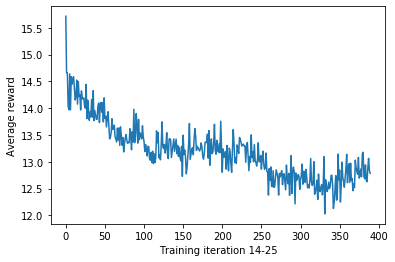

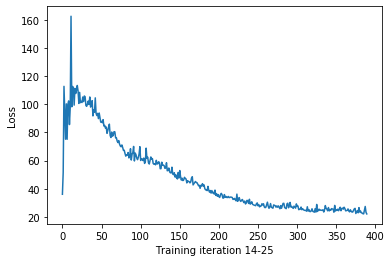

Generating molecules...: : 11it [00:06,  1.76it/s]                      
                                             

Mean value of predictions: 7.769032944844125


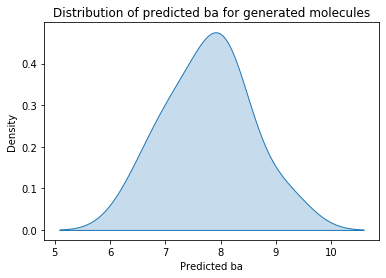

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

25th Sample trajectories:
CCC[N+]([O-])(C1CCN(c2ccc(C#N)cn2)CC1F)C(C)(C)C
CN(C)C(=O)C(=O)c1cnn2cccc2c1NC1CCCC1(C)C
CN(C)C(=O)c1cn(C2CC3(CCC2C#N)OCCO3)nc1Nc1ccccc1
CN(C)C(=O)n1cc(C(N)=O)c(Nc2ccc(CN)cc2)n1
CN(C)C(C)(C)c1[nH]c(-c2ccnc(N)n2)cc1C(N)=O
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
Policy gradient...:   7%|▋         | 1/15 [00:04<01:05,  4.65s/it]

0th cur_reward, cur_loss:  11.968151217089192 28.25860595703125



100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.50it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

1th cur_reward, cur_loss:  14.609325332233997 11.936456680297852



100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.78it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

2th cur_reward, cur_loss:  13.749926886912972 23.005699157714844



100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.89it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

3th cur_reward, cur_loss:  11.064852082419486 12.202622413635254



100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:23<00:47,  4.74s/it]

4th cur_reward, cur_loss:  9.119340366703923 15.132391929626465



100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
Policy gradient...:  40%|████      | 6/15 [00:32<00:55,  6.14s/it]

5th cur_reward, cur_loss:  11.464162255609844 35.06803894042969



100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.51it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:35<00:41,  5.24s/it]

6th cur_reward, cur_loss:  12.775297596632967 13.847628593444824



100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

7th cur_reward, cur_loss:  9.502743004072379 20.338817596435547



100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.86it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [00:43<00:26,  4.43s/it]

8th cur_reward, cur_loss:  14.099959716596672 24.75



100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [00:48<00:22,  4.54s/it]

9th cur_reward, cur_loss:  13.79635635069395 15.5889310836792



100%|██████████| 1/1 [00:00<00:00,  3.96it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [00:56<00:22,  5.72s/it]

10th cur_reward, cur_loss:  15.801921830911903 30.581958770751953



100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [01:04<00:19,  6.45s/it]

11th cur_reward, cur_loss:  13.835397651665367 19.8283634185791



100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

12th cur_reward, cur_loss:  11.450063452995204 26.5383358001709



100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

13th cur_reward, cur_loss:  10.82898552979105 16.939558029174805



100%|██████████| 1/1 [00:00<00:00,  3.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.76it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:16<00:00,  5.10s/it]


14th cur_reward, cur_loss:  9.479454866293889 7.121284484863281


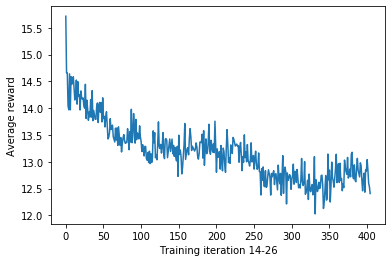

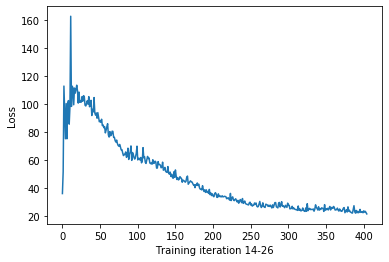

Generating molecules...: : 11it [00:07,  1.47it/s]                      


Mean value of predictions: 7.852989872702163


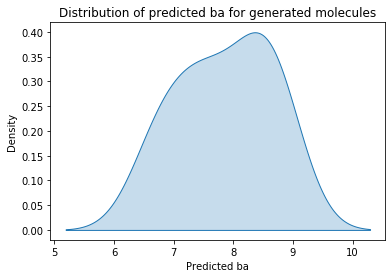

  0%|          | 0/1 [00:00<?, ?it/s]

26th Sample trajectories:
CC(Nc1nc(Nc2cn(C(=O)C(C)(C)N(C)C)cn2)c2cccnc2n1)c1ncc(F)cn1
CCCS(=O)(=O)CC1CC(N(c2ncnc3[nH]ccc23)N(C)C)C1
CCN(C)C(=O)N(C)c1ncnc2[nH]ccc12
CN(C(C)(C)C)C(C)(C)c1cc2c(NC3CCC(C)(C(N)=O)C3(C)C)c(C(N)=O)cnn2c1
CN(C)C(=O)CC1C2CN(C3CCC(n4cc(C(N)=O)c(Nc5ccc(C(F)(F)F)cc5)n4)C(C#N)C3)CC12
###################################################################



100%|██████████| 1/1 [00:00<00:00,  3.75it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  3.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.54it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

  0%|          | 0/1 [00:00<?, ?it/s]

0th cur_reward, cur_loss:  13.046150636796403 9.01923656463623



100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

1th cur_reward, cur_loss:  13.383932480849726 23.75592613220215



100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.79it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

2th cur_reward, cur_loss:  13.080716484158925 8.328824996948242



100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.75it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [00:15<00:46,  4.24s/it]

3th cur_reward, cur_loss:  12.746627004661223 28.907405853271484



100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:22<00:53,  5.31s/it]

4th cur_reward, cur_loss:  13.347920326284157 33.71343994140625



100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                                             
Policy gradient...:  40%|████      | 6/15 [00:27<00:45,  5.00s/it]

5th cur_reward, cur_loss:  13.095068266704613 29.590600967407227



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:32<00:41,  5.21s/it]

6th cur_reward, cur_loss:  14.324450729624875 36.21997833251953



100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

7th cur_reward, cur_loss:  14.119210213273021 21.729942321777344



100%|██████████| 1/1 [00:00<00:00,  3.89it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

8th cur_reward, cur_loss:  14.674130356149817 14.359848022460938



100%|██████████| 1/1 [00:00<00:00,  3.46it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.18it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

9th cur_reward, cur_loss:  9.210567625215878 8.726419448852539



100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.94it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [00:49<00:17,  4.38s/it]

10th cur_reward, cur_loss:  12.832758723106858 23.36701202392578



100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.96it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [00:55<00:14,  4.80s/it]

11th cur_reward, cur_loss:  10.247525389223592 18.292861938476562



100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.28it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.19it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

12th cur_reward, cur_loss:  8.973653427026273 24.624786376953125



100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

13th cur_reward, cur_loss:  11.045748289424413 14.663104057312012



100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:04<00:00,  4.28s/it]


14th cur_reward, cur_loss:  17.173134959684482 24.2993106842041


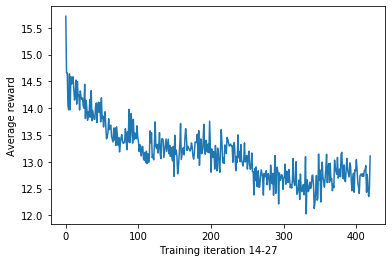

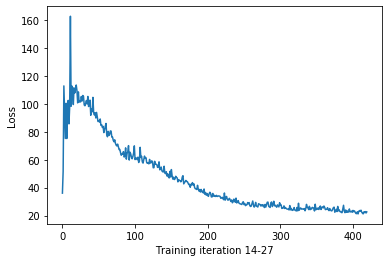

Generating molecules...: : 11it [00:05,  2.11it/s]                      
                                             

Mean value of predictions: 7.525512241868183


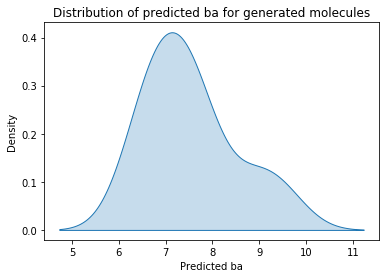

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

27th Sample trajectories:
CC(C)C(Nc1cc(-c2ccoc2)nc(-n2cnc3ccncc32)n1)[N+](C)(C)[O-]
CC(NC(=O)c1c[nH]c2ncc(C3CC3)nc12)C(C)(C)CCN(C)C
CN(C)C(=O)N(c1ncnc2[nH]ccc12)C1CCC(CS(=O)(=O)N2CCC(S(=O)(=O)CCc3ccccc3)C2)CC1
CN(C)CC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1
CN(C)CNc1ncc(C(F)(F)F)cc1Cl
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  4.50it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
Policy gradient...:   7%|▋         | 1/15 [00:05<01:22,  5.87s/it]

0th cur_reward, cur_loss:  14.840864722880383 37.645057678222656



100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
Policy gradient...:  13%|█▎        | 2/15 [00:09<01:02,  4.81s/it]

1th cur_reward, cur_loss:  10.647215874916718 19.735931396484375



100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:15<01:02,  5.19s/it]

2th cur_reward, cur_loss:  14.67787918304515 48.038116455078125



100%|██████████| 1/1 [00:00<00:00,  3.48it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.68it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

3th cur_reward, cur_loss:  15.410040239897437 28.1019344329834



100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

4th cur_reward, cur_loss:  13.51439546090428 10.799732208251953



100%|██████████| 1/1 [00:00<00:00,  3.45it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

5th cur_reward, cur_loss:  12.556610778947768 43.079017639160156



100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:31<00:32,  4.08s/it]

6th cur_reward, cur_loss:  15.143727908418683 20.41971778869629



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

7th cur_reward, cur_loss:  13.549783532136255 20.698530197143555



100%|██████████| 1/1 [00:00<00:00,  3.79it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [00:38<00:22,  3.68s/it]

8th cur_reward, cur_loss:  14.278542284039034 14.732455253601074



100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

9th cur_reward, cur_loss:  12.223368460855786 17.744298934936523



100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.51it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

10th cur_reward, cur_loss:  17.34566990093739 112.58065795898438



100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [00:55<00:13,  4.65s/it]

11th cur_reward, cur_loss:  16.123059221971648 14.607969284057617



100%|██████████| 1/1 [00:00<00:00,  3.89it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.26it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

12th cur_reward, cur_loss:  14.16465305053991 22.742347717285156



100%|██████████| 1/1 [00:00<00:00,  3.48it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.88it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:02<00:04,  4.19s/it]

13th cur_reward, cur_loss:  11.867517544807514 9.852212905883789



100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:06<00:00,  4.44s/it]


14th cur_reward, cur_loss:  13.280250160471235 9.29459285736084


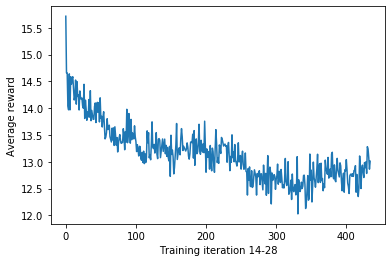

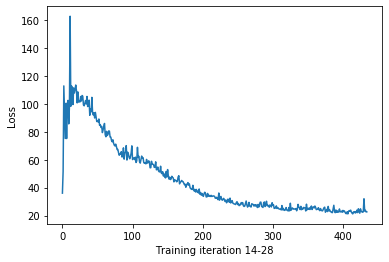

Generating molecules...: : 11it [00:07,  1.51it/s]                      


Mean value of predictions: 7.334827744590004


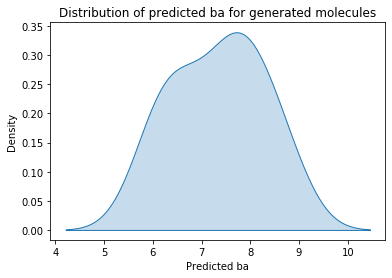

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

28th Sample trajectories:
CC(CN(C)C)N(c1ncnc2[nH]ccc12)C1CCC(CS(=O)(=O)N2CCCC(CS(C)(=O)=O)C2)CC1
CN(C)C(=O)c1ccc2[nH]nc(N)c2c1
CN(C)C(=O)c1cnn2cc(-c3cccc(Cl)c3)cc2c1NC1CCC(C)(N)C1(C)C
CN(C)N(C)CC=CC(=O)Nc1cc2c(Nc3ccc(Oc4ccccc4)cc3)ncnc2cn1
CN(C)N1CCc2c(nn(Cc3ccccc3)c2Br)C1=O
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
Policy gradient...:   7%|▋         | 1/15 [00:05<01:10,  5.04s/it]

0th cur_reward, cur_loss:  16.891730267445535 27.524938583374023



100%|██████████| 1/1 [00:00<00:00,  4.17it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

Policy gradient...:  13%|█▎        | 2/15 [00:08<00:52,  4.01s/it]

1th cur_reward, cur_loss:  15.500149703649091 15.246963500976562



100%|██████████| 1/1 [00:00<00:00,  3.79it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.25it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

2th cur_reward, cur_loss:  14.0006422285557 35.88905715942383



100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.92it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [00:16<00:46,  4.20s/it]

3th cur_reward, cur_loss:  13.994594477189702 34.23598861694336



100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.79it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

4th cur_reward, cur_loss:  14.677428414089189 20.61711883544922



100%|██████████| 1/1 [00:00<00:00,  3.83it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

5th cur_reward, cur_loss:  14.366291035766498 7.967175483703613



100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

6th cur_reward, cur_loss:  12.827060769445849 33.392845153808594



100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

7th cur_reward, cur_loss:  15.024827112764546 35.33628463745117



100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [00:37<00:29,  4.84s/it]

8th cur_reward, cur_loss:  17.21705608956374 32.3772087097168



100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

9th cur_reward, cur_loss:  14.647990958242753 17.980236053466797



100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

10th cur_reward, cur_loss:  9.956572675075765 27.54973793029785



100%|██████████| 1/1 [00:00<00:00,  3.81it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.79it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [00:52<00:14,  4.68s/it]

11th cur_reward, cur_loss:  14.822939020077325 25.87440299987793



100%|██████████| 1/1 [00:00<00:00,  3.96it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

12th cur_reward, cur_loss:  15.59834758516147 31.94330406188965



100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.84it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

13th cur_reward, cur_loss:  12.818566288245252 13.285476684570312



100%|██████████| 1/1 [00:00<00:00,  3.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:04<00:00,  4.29s/it]


14th cur_reward, cur_loss:  17.54687684245613 13.047261238098145


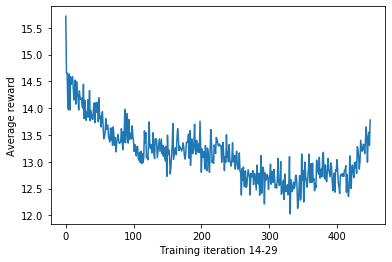

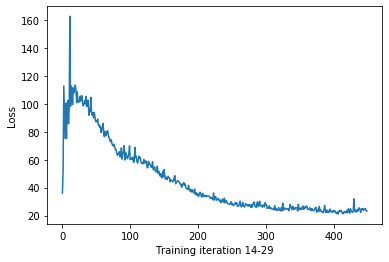

Generating molecules...: : 11it [00:10,  1.07it/s]                      


Mean value of predictions: 7.693891989417888


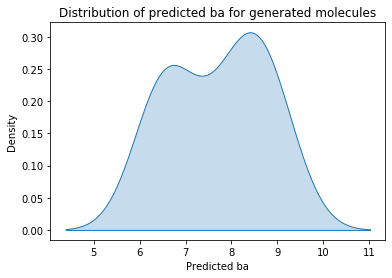

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

29th Sample trajectories:
CC(c1nc2c3ccccc3c3ccccc3c2[nH]1)C(C)[N+](C)(C)[O-]
CC1CC(Nc2ncccc2N(C)C(C)(C)C)CN(S(C)(=O)=O)C1
CCC1(C)CCCC1Nc1c(C(N)=O)cnn2cccc12
CCN(C)C1CCC(c2nnn3cnc4[nH]ccc4c23)CC1
CCc1cc(O)c(F)cc1N(C)C
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

  0%|          | 0/1 [00:00<?, ?it/s]

0th cur_reward, cur_loss:  12.951684645099084 11.785391807556152



100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.84it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.82it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
Policy gradient...:  13%|█▎        | 2/15 [00:05<00:39,  3.03s/it]

1th cur_reward, cur_loss:  12.758693992645508 20.781631469726562



100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.82it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.12it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                                             
Policy gradient...:  20%|██        | 3/15 [00:09<00:39,  3.33s/it]

2th cur_reward, cur_loss:  11.188202947554917 11.286216735839844



100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.87it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.77it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

3th cur_reward, cur_loss:  13.949579508882158 18.840023040771484



100%|██████████| 1/1 [00:00<00:00,  3.61it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.85it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

4th cur_reward, cur_loss:  13.042550028632542 13.197554588317871



100%|██████████| 1/1 [00:00<00:00,  3.96it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

5th cur_reward, cur_loss:  13.546898254698569 32.368831634521484



100%|██████████| 1/1 [00:00<00:00,  3.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.83it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.86it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

6th cur_reward, cur_loss:  12.590609037634463 21.293848037719727



100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
Policy gradient...:  53%|█████▎    | 8/15 [00:26<00:26,  3.73s/it]

7th cur_reward, cur_loss:  16.752757530964235 84.7594223022461



100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [00:33<00:28,  4.79s/it]

8th cur_reward, cur_loss:  14.264996069576148 5.723276615142822



100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.24it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.80it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [00:40<00:27,  5.56s/it]

9th cur_reward, cur_loss:  15.609499453645743 8.38667106628418



100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [00:45<00:20,  5.20s/it]

10th cur_reward, cur_loss:  14.214140169469239 29.297962188720703



100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.92it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.50it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [00:50<00:15,  5.24s/it]

11th cur_reward, cur_loss:  12.198537629488374 7.999038219451904



100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [00:56<00:11,  5.56s/it]

12th cur_reward, cur_loss:  15.065704759248678 25.41046142578125



100%|██████████| 1/1 [00:00<00:00,  3.54it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.74it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.70it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [00:59<00:04,  4.69s/it]

13th cur_reward, cur_loss:  15.371231932405488 46.48350143432617



100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:05<00:00,  4.35s/it]


14th cur_reward, cur_loss:  16.349363621200695 36.64133834838867


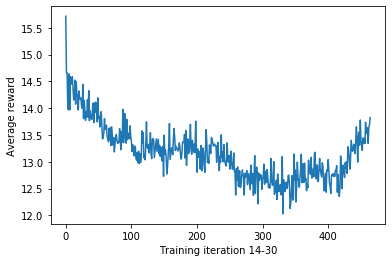

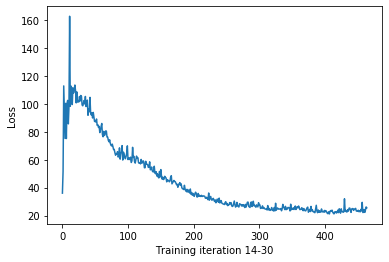

Generating molecules...: : 11it [00:07,  1.54it/s]                      
                                             

Mean value of predictions: 7.675052165378564


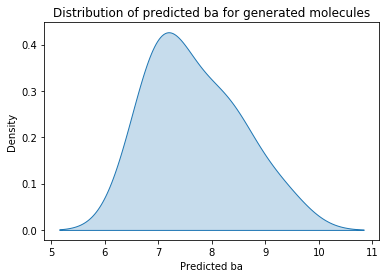

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

30th Sample trajectories:
CC(C)C(=O)C(C)NC(=O)c1c[nH]c2ncc(C3CC3)nc12
CC1CCN(C(=O)CC#N)CC1n1c(=O)n(NC(C)(C)C)c2cnc3[nH]ccc3c21
CCc1cc(O)c(F)cc1C
CN(C)C(=O)N1CC(N(C)c2ncnc3[nH]ccc23)C2(CC2)C1
CN(C)C(C)(C)Cc1cccn2nc(Nc3ccc(C4CCNCC4)cc3)nc12
###################################################################



100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
Policy gradient...:   7%|▋         | 1/15 [00:06<01:25,  6.11s/it]

0th cur_reward, cur_loss:  14.007632020347232 15.544219017028809



100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

1th cur_reward, cur_loss:  14.268559369100927 59.451759338378906



100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.51it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

2th cur_reward, cur_loss:  17.86852353193129 29.092884063720703



100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
                                             
Policy gradient...:  27%|██▋       | 4/15 [00:23<01:04,  5.89s/it]

3th cur_reward, cur_loss:  12.916297986860974 14.061491966247559



100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.51it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

4th cur_reward, cur_loss:  14.477331633325374 13.389906883239746



100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
Policy gradient...:  40%|████      | 6/15 [00:31<00:41,  4.61s/it]

5th cur_reward, cur_loss:  13.255458507104043 33.32535171508789



100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
Policy gradient...:  47%|████▋     | 7/15 [00:33<00:31,  3.92s/it]

6th cur_reward, cur_loss:  12.573176036579028 42.146812438964844



100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.28it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

7th cur_reward, cur_loss:  10.875918196167115 25.07587432861328



100%|██████████| 1/1 [00:00<00:00,  3.45it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.18it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.66it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [00:42<00:24,  4.13s/it]

8th cur_reward, cur_loss:  15.27716955528754 29.115570068359375



100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

9th cur_reward, cur_loss:  12.740284872211072 30.1685733795166



100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.51it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                                             
Policy gradient...:  73%|███████▎  | 11/15 [00:50<00:15,  3.87s/it]

10th cur_reward, cur_loss:  16.19671547058093 68.88219451904297



100%|██████████| 1/1 [00:00<00:00,  3.53it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
Policy gradient...:  80%|████████  | 12/15 [00:55<00:13,  4.34s/it]

11th cur_reward, cur_loss:  13.72672870338613 7.994711875915527



100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

12th cur_reward, cur_loss:  15.614992485661576 21.592967987060547



100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                                             
Policy gradient...:  93%|█████████▎| 14/15 [01:10<00:05,  5.68s/it]

13th cur_reward, cur_loss:  17.095827594992333 24.32009506225586



100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.68it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:15<00:00,  5.04s/it]


14th cur_reward, cur_loss:  17.303954499334107 30.439306259155273


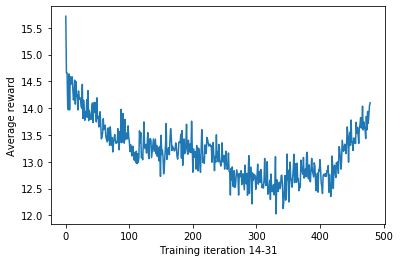

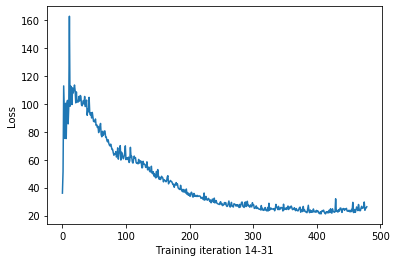

Generating molecules...: : 11it [00:10,  1.09it/s]                      


Mean value of predictions: 8.35961367377229


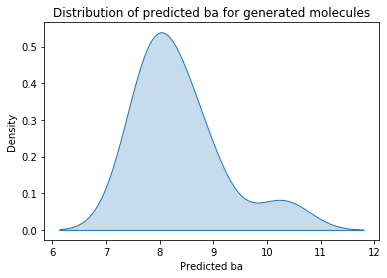

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

31th Sample trajectories:
CCC(C)(C)N(C)n1cc(C(N)=O)c(Nc2ccc(C#N)cc2)n1
CCN(CC)C(=O)Oc1ccc(-c2nc3c(NCC4CCNC4)c(Cl)cnc3[nH]2)cc1
CN(C)C(=O)CC(=O)c1cn(C2C(F)CCCC2C#N)nc1Nc1ccccc1
CN(C)C(=O)Cn1cc(C(N)=O)c(Nc2ccc(F)cc2)n1
CN(C)C(=O)OCc1ccc2c(c1)c1c3c(c4c5cc(Br)ccc5n5c4c1n2CC(CO)C5)C(=O)NC3
###################################################################



100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  3.83it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.50it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

0th cur_reward, cur_loss:  16.807152060796696 25.409881591796875



100%|██████████| 1/1 [00:00<00:00,  4.22it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.

100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

1th cur_reward, cur_loss:  10.90082367350899 15.964306831359863



100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.81it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

2th cur_reward, cur_loss:  11.805198853278451 27.35968017578125



100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

3th cur_reward, cur_loss:  11.443034826324498 30.420209884643555



100%|██████████| 1/1 [00:00<00:00,  3.87it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
                                             
Policy gradient...:  33%|███▎      | 5/15 [00:19<00:39,  3.91s/it]

4th cur_reward, cur_loss:  13.499911402294895 18.092626571655273



100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.50it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

5th cur_reward, cur_loss:  13.536671376674537 12.924059867858887



100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

6th cur_reward, cur_loss:  13.120237987096683 8.875571250915527



100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.96it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.89it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

7th cur_reward, cur_loss:  13.872076998869343 81.87395477294922



100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                                             
Policy gradient...:  60%|██████    | 9/15 [00:42<00:31,  5.33s/it]

8th cur_reward, cur_loss:  12.682909104433763 43.8721809387207



100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                                             
Policy gradient...:  67%|██████▋   | 10/15 [00:49<00:28,  5.64s/it]

9th cur_reward, cur_loss:  13.589806718636812 29.643857955932617



100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.19it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.87it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

10th cur_reward, cur_loss:  13.237793663359993 46.42887878417969



100%|██████████| 1/1 [00:00<00:00,  3.78it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

11th cur_reward, cur_loss:  11.734018481883236 20.02027702331543



100%|██████████| 1/1 [00:00<00:00,  3.45it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.58it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
Policy gradient...:  87%|████████▋ | 13/15 [01:03<00:10,  5.18s/it]

12th cur_reward, cur_loss:  14.482512108553777 16.337677001953125



100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.86it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
                                             
  0%|          | 0/1 [00:00<?, ?it/s]

13th cur_reward, cur_loss:  11.46434859330971 28.642187118530273



100%|██████████| 1/1 [00:00<00:00,  3.92it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
                                             
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                                             
Policy gradient...: 100%|██████████| 15/15 [01:11<00:00,  4.76s/it]


14th cur_reward, cur_loss:  15.71291699450126 15.344788551330566


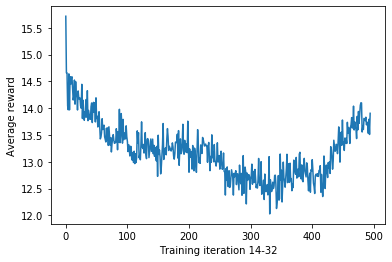

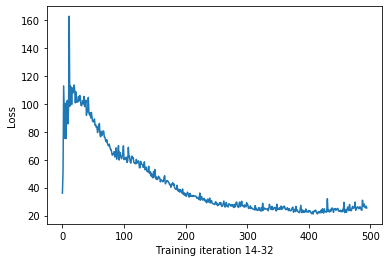

Generating molecules...: : 11it [00:03,  2.88it/s]                      


Mean value of predictions: 7.7501214825025615


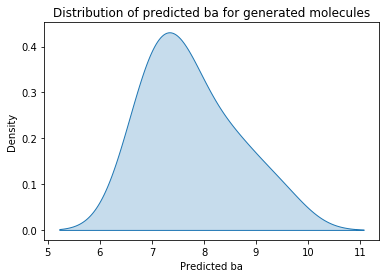

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

32th Sample trajectories:
CC(C[N+](C)(C)[O-])C(=O)c1cn(C2(CC#N)CN(C(=O)OC3CCOCC3)C2)nc1Nc1ccc(S(C)(=O)=O)cc1
CCN(C)C(=O)C(=O)N1CC(CC#N)(n2cc(C(N)=O)c(Nc3ccccc3)n2)C1
CCN(C)C(=O)C(=O)c1cccc(Nc2cc(Nc3cc(C)c(F)cn3)ncc2C(=O)NC)c1OC
CCOc1ccc(N2CCC(CC#N)(n3cc(C(=O)N(C)C(C)(C)C)c(Nc4ccc(F)cc4)n3)CC2)cn1
CN(C)C(=O)c1cn(C2COCCC2C#N)nc1Nc1ccc(Cl)nc1
###################################################################



100%|██████████| 1/1 [00:00<00:00,  3.81it/s]
                                             /home/sumin/miniconda3/envs/lib-invent/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                                             
Policy gradient...:   0%|          | 0/15 [07:22<?, ?it/s]


KeyboardInterrupt: 

In [20]:
rewards_max = []
rl_losses_max = []
n_iterations = 100
n_policy = 15
# n_iterations = 10
# n_policy = 5
for i in range(n_iterations):
    print("###################################################################")
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_max.policy_gradient(gen_data, n_batch=5)
        print(f"{j}th cur_reward, cur_loss: ", cur_reward, cur_loss)
        #pdb.set_trace()
        rewards_max.append(simple_moving_average(rewards_max, cur_reward)) 
        rl_losses_max.append(simple_moving_average(rl_losses_max, cur_loss))

    plt.plot(rewards_max)
    plt.xlabel(f'Training iteration {j}-{i}')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses_max)
    plt.xlabel(f'Training iteration {j}-{i}')
    plt.ylabel('Loss')
    plt.show()
    
    smiles_cur, prediction_cur = estimate_and_update(RL_max.generator, 
                                                     predictor, gen_data, 10)
    print(f'{i}th Sample trajectories:')
    for sm in smiles_cur[:5]:
        print(sm)

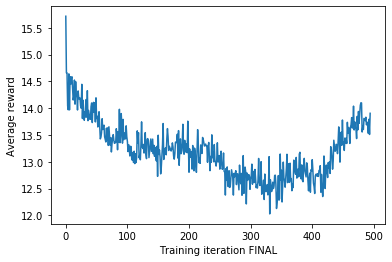

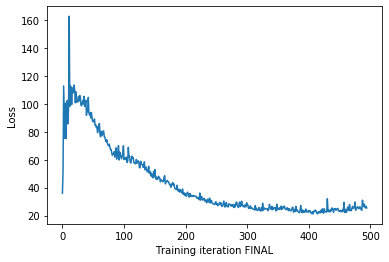

In [21]:
plt.plot(rewards_max)
plt.xlabel('Training iteration FINAL')
plt.ylabel('Average reward')
plt.show()
plt.plot(rl_losses_max)
plt.xlabel(f'Training iteration FINAL')
plt.ylabel('Loss')
plt.show()

#jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

### Generated Molecules

In [3]:
import pickle
with open("save_dict.pkl", "rb") as f:
    save_dict = pickle.load(f)

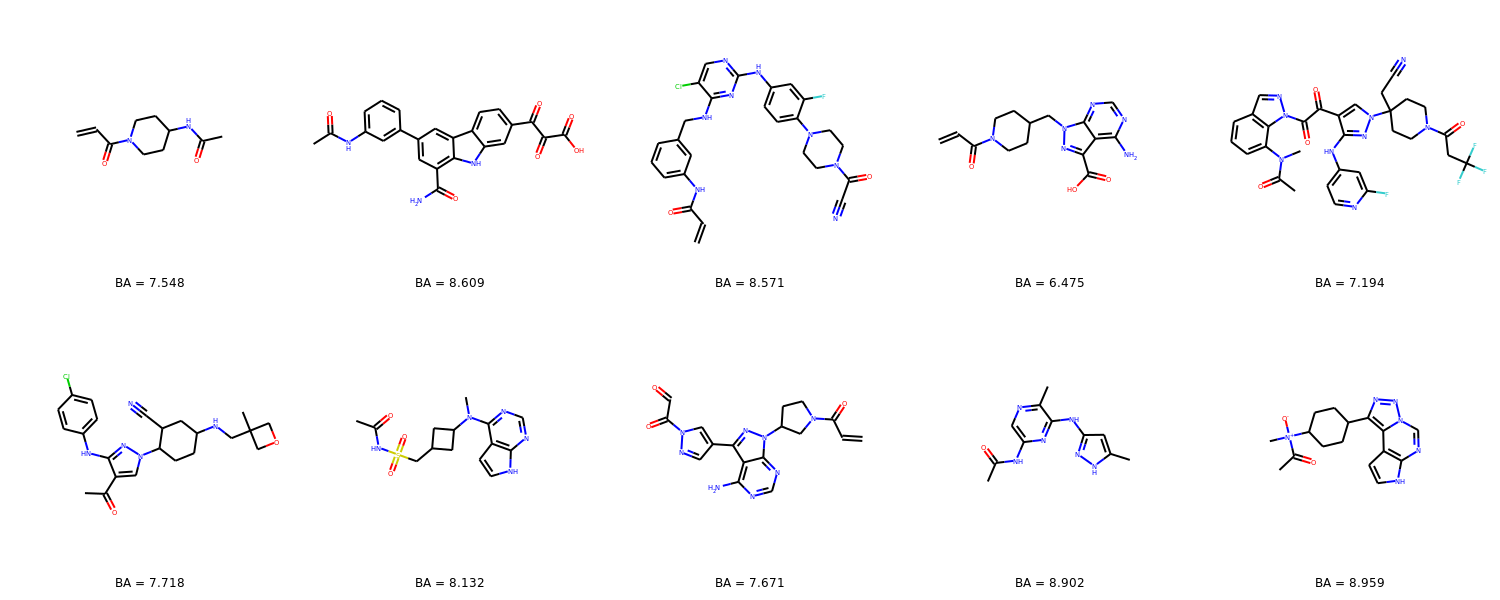

In [8]:
from rdkit import Chem
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

n_to_draw = 10
sanitized_gen_mols_max = [Chem.MolFromSmiles(sm, sanitize=True) for sm in save_dict['optimized_smiles'][:100]]
ind = np.random.randint(0, len(sanitized_gen_mols_max), n_to_draw)
mols_to_draw_max = [sanitized_gen_mols_max[i] for i in ind]
legends = ['BA = ' + "{:.3f}".format(save_dict['optimized_scores'][i]) for i in ind]
Draw.MolsToGridImage(mols_to_draw_max, molsPerRow=5, 
                     subImgSize=(300,300), legends=legends)